# Phase 3 - Modeling

**Note 1: the following starting code only generates a single random train/test split when default_seed is used. You need to modify the code to generate 100 independent train/test splits with different seeds and report the average results on those independent splits along with standard deviation.**

**Note 2: You are completely free to use your own implementation.**

In [1]:
# Load general utilities
# ----------------------
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import datetime
import numpy as np
import pickle
import time
import seaborn as sns
pd.set_option('display.max_rows',99999999)
pd.set_option('display.max_columns',100)
pd.set_option('display.max_colwidth',100)
pd.set_option('display.width',None)

# Load sklearn utilities
# ----------------------
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, brier_score_loss, mean_squared_error, r2_score
from sklearn.metrics import precision_score,recall_score,f1_score
from sklearn.calibration import calibration_curve

# Load classifiers
# ----------------
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier

# Other Packages
# --------------
from scipy.stats import kendalltau
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
from scipy.interpolate import spline

# Load debugger, if required
#import pixiedust
pd.options.mode.chained_assignment = None #'warn'

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Define a function that, given a CVGridSearch object, finds the
# percentage difference between the best and worst scores
def find_score_variation(cv_model):
    all_scores = cv_model.cv_results_['mean_test_score']
    return( np.abs((max(all_scores) - min(all_scores))) * 100 / max(all_scores) )

    '''
    which_min_score = np.argmin(all_scores)
    
    all_perc_diff = []
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score - 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score + 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    return ( np.mean(all_perc_diff) )
    '''

# Define a function that checks, given a CVGridSearch object,
# whether the optimal parameters lie on the edge of the search
# grid
def find_opt_params_on_edge(cv_model):
    out = False
    
    for i in cv_model.param_grid:
        if cv_model.best_params_[i] in [ cv_model.param_grid[i][0], cv_model.param_grid[i][-1] ]:
            out = True
            break
            
    return out

## Define a default random seed and an output file

In [3]:
default_seed = 1
output_file = "output_sample"

In [4]:
# Create a function to print a line to our output file

def dump_to_output(key, value):
    with open(output_file, "a") as f:
        f.write(",".join([str(default_seed), key, str(value)]) + "\n")

## Load the data and engineer the features

In [5]:
# Read the data and features from the pickle file saved in CS-Phase 2
data, discrete_features, continuous_features, ret_cols = pickle.load( open( "clean_data.pickle", "rb" ) )

In [6]:
## Create the outcome columns: True if loan_status is either Charged Off or Default, False otherwise
data["outcome"] = np.where(data.loan_status.isin(['Charged Off','Default']),True,False)

In [7]:
# Create a feature for the length of a person's credit history at the time the loan is issued
data['cr_hist'] = (data.issue_d - data.earliest_cr_line) / np.timedelta64(1, 'M')
continuous_features.append('cr_hist')

In [8]:
# Randomly assign each row to a training and test set. We do this now because we will be fitting a variety of models on various time periods, and we would like every period to use the *same* training/test split
np.random.seed(default_seed)
## create the train columns where the value is True if it is a train instance and False otherwise. Hint: use np.random.choice with 70% for training and 30% for testing
p=[0.3,0.7]
data['train'] = np.random.choice(len(p),len(data),p=p)
data.train.value_counts()

1    613864
0    263417
Name: train, dtype: int64

In [9]:
continuous_features

['loan_amnt',
 'funded_amnt',
 'installment',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'open_acc',
 'pub_rec',
 'fico_range_high',
 'fico_range_low',
 'revol_bal',
 'cr_hist']

In [10]:
datafr = data.head(800)
q = datafr['annual_inc']

In [11]:
# Create a matrix of features and outcomes, with dummies. Record the names of the dummies for later use
X_continuous = data[continuous_features].values

X_discrete = pd.get_dummies(data[discrete_features], dummy_na = True, 
                            prefix_sep = "::", drop_first = True)

discrete_features_dummies = X_discrete.columns.tolist()

X_discrete = X_discrete.values

X = np.concatenate( (X_continuous, X_discrete), axis = 1 )

y = data.outcome.values

train = data.train.values

In [12]:
all_col = continuous_features + discrete_features_dummies

df = pd.DataFrame(X,y,columns=all_col)

df = df.reset_index()

df.drop(columns=['index'], inplace = True)

columns_to_remove = ['home_ownership::nan','purpose::nan',
                     'emp_length::nan','verification_status::nan',
                     'term::nan','grade::nan']

df.drop(columns=columns_to_remove, inplace = True)

#Scaling the dataset
data_scaled = (df - df.mean()) / (df.std())

#Updating the discrete_features
for x in columns_to_remove:
    discrete_features_dummies.remove(x)

### Creating the new X and Y based on feature selection ( NaN as of now )

In [13]:
# Create a matrix of features and outcomes, with dummies. Record the names of the dummies for later use
X_continuous = df[continuous_features].values

X_discrete = df[discrete_features_dummies].values

X = np.concatenate( (X_continuous, X_discrete), axis = 1 )

y = data.outcome.values

train = data.train.values

In [14]:
def plot_correlation(dataframe):
    
    import plotly.offline as py
    py.init_notebook_mode(connected=True)
    import plotly.graph_objs as go
    import plotly.tools as tls
    import plotly.figure_factory as ff
    
    #Pearson correlation
    correlation = dataframe.corr()
    #tick labels
    matrix_cols = correlation.columns.tolist()
    #convert to array
    corr_array  = np.array(correlation)

    #Plotting
    trace = go.Heatmap(z = corr_array,
                       x = matrix_cols,
                       y = matrix_cols,
                       colorscale = "Viridis",
                       colorbar   = dict(title = "Pearson Correlation coefficient",
                                         titleside = "right"
                                        ) ,
                      )

    layout = go.Layout(dict(title = "Correlation Matrix for variables",
                            autosize = False,
                            height  = 720,
                            width   = 800,
                            margin  = dict(r = 0 ,l = 210,
                                           t = 25,b = 210,
                                          ),
                            yaxis   = dict(tickfont = dict(size = 9)),
                            xaxis   = dict(tickfont = dict(size = 9))
                           )
                      )

    data1 = [trace]
    fig = go.Figure(data=data1,layout=layout)
    py.iplot(fig)

plot_correlation(data_scaled)

## Prepare functions to fit and evaluate models

In [15]:
def prepare_data(data_subset = np.array([True]*len(data)),
                    n_samples_train = 30000,
                    n_samples_test = 20000,
                    feature_subset = None,
                    date_range_train = (data.issue_d.min(), data.issue_d.max()),
                    date_range_test = (data.issue_d.min(), data.issue_d.max()),
                    random_state = default_seed):
    '''
    This function will prepare the data for classification or regression.
    It expects the following parameters:
      - data_subset: a numpy array with as many entries as rows in the
                     dataset. Each entry should be True if that row
                     should be used, or False if it should be ignored
      - n_samples_train: the total number of samples to be used for training.
                         Will trigger an error if this number is larger than
                         the number of rows available after all filters have
                         been applied
      - n_samples_test: as above for testing
      - feature_subect: A list containing the names of the features to be
                        used in the model. In None, all features in X are
                        used
      - date_range_train: a tuple containing two dates. All rows with loans
                          issued outside of these two dates will be ignored in
                          training
      - date_range_test: as above for testing
      - random_state: the random seed to use when selecting a subset of rows
      
    Note that this function assumes the data has a "Train" column, and will
    select all training rows from the rows with "True" in that column, and all
    the testing rows from those with a "False" in that column.
    
    This function returns a dictionary with the following entries
      - X_train: the matrix of training data
      - y_train: the array of training labels
      - train_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the train set
      - X_test: the matrix of testing data
      - y_test: the array of testing labels
      - test_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the test set
    '''
    
    np.random.seed(random_state)
        
    # Filter down the data to the required date range, and downsample
    # as required
    filter_train = ( train & (data.issue_d >= date_range_train[0]) &
                            (data.issue_d <= date_range_train[1]) & data_subset ).values
    filter_test = ( (train == False) & (data.issue_d >= date_range_test[0])
                            & (data.issue_d <= date_range_test[1]) & data_subset ).values
    
    filter_train[ np.random.choice( np.where(filter_train)[0], size = filter_train.sum()
                                                   - n_samples_train, replace = False ) ] = False
    filter_test[ np.random.choice( np.where(filter_test)[0], size = filter_test.sum()
                                                   - n_samples_test, replace = False ) ] = False
    
    # Prepare the training and test set
    X_train = X[ filter_train , :]
    X_test = X[ filter_test, :]
    if feature_subset != None:
        cols = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in feature_subset]
        X_train = X_train[ : , cols ]
        X_test = X_test[ : , cols ]
        
    y_train = y[ filter_train ]
    y_test = y[ filter_test ]
    
    # Scale the variables
    scaler = preprocessing.MinMaxScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # return training and testing data
    out = {'X_train':X_train, 'y_train':y_train, 'train_set':filter_train, 
           'X_test':X_test, 'y_test':y_test, 'test_set':filter_test}
    
    return out

In [16]:
def fit_classification(model, data_dict,
                          cv_parameters = {},
                          model_name = None,
                          random_state = default_seed,
                          output_to_file = True,
                          print_to_screen = True):
    '''
    This function will fit a classification model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    If the model provided does not have a predict_proba function, we will
    simply print accuracy diagnostics and return.
    
    If the model provided does have a predict_proba function, we first
    figure out the optimal threshold that maximizes the accuracy and
    print out accuracy diagnostics. We then print an ROC curve, sensitivity/
    specificity curve, and calibration curve.
    
    This function returns a dictionary with the following entries
      - model: the best fitted model
      - y_pred: predictions for the test set
      - y_pred_probs: probability predictions for the test set, if the model
                      supports them
      - y_pred_score: prediction scores for the test set, if the model does not 
                      output probabilities.
    '''
        
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    X_train = data_dict['X_train']
    y_train = data_dict['y_train']
    
    X_test = data_dict['X_test']
    y_test = data_dict['y_test']
    
    filter_train = data_dict['train_set']    
  
    # --------------------------
    #   Step 2 - Fit the model
    # --------------------------

    cv_model = GridSearchCV(model, cv_parameters)
    
    start_time = time.time()
    cv_model.fit(X_train, y_train)
    end_time = time.time()
    
    best_model = cv_model.best_estimator_
    
    if print_to_screen:

        if model_name != None:
            print("=========================================================")
            print("  Model: " + model_name)
            print("=========================================================")

        print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
        print("Optimal parameters:")
        print(cv_model.best_params_)
        print("")
    
    # -------------------------------
    #   Step 3 - Evaluate the model
    # -------------------------------
    
    # If possible, make probability predictions
    try:
        y_pred_probs = best_model.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
        
        probs_predicted = True
    except:
        probs_predicted = False
    
    # Make predictions; if we were able to find probabilities, use
    # the threshold that maximizes the accuracy in the training set.
    # If not, just use the learner's predict function
    if probs_predicted:
        y_train_pred_probs = best_model.predict_proba(X_train)[:,1]
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_probs)
        
        true_pos_train = tpr_train*(y_train.sum())
        true_neg_train = (1 - fpr_train) *(1-y_train).sum()
        
        best_threshold_index = np.argmax(true_pos_train + true_neg_train)
        best_threshold = 1 if best_threshold_index == 0 else thresholds_train[ best_threshold_index ]
        
        if print_to_screen:
            print("Accuracy-maximizing threshold was: " + str(best_threshold))
        
        y_pred = (y_pred_probs > best_threshold)
    else:
        y_pred = best_model.predict(X_test)
    scores = {}
    if print_to_screen:
        print("Accuracy: ", accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred, target_names =['No default', 'Default'], digits = 4))
    scores['Accuracy'] = accuracy_score(y_test, y_pred)
    scores['precision'] = precision_score(y_test, y_pred)
    scores['recall'] = recall_score(y_test, y_pred)
    scores['f1'] = f1_score(y_test, y_pred)
    scores['roc_auc_score'] = roc_auc_score(y_test, y_pred_probs)
    if print_to_screen:
        if probs_predicted:        
            plt.figure(figsize = (13, 4.5))
            plt.subplot(2, 2, 1)

            plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, y_pred_probs))
            plt.plot(fpr, tpr, 'b')
            plt.plot([0,1],[0,1],'r--')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')

            plt.subplot(2, 2, 3)

            plt.plot(thresholds, tpr, 'b', label = 'Sensitivity')
            plt.plot(thresholds, 1 -fpr, 'r', label = 'Specificity')
            plt.legend(loc = 'lower right')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.xlabel('Threshold')

            plt.subplot(2, 2, 2)

            fp_0, mpv_0 = calibration_curve(y_test, y_pred_probs, n_bins = 10)
            plt.plot([0,1], [0,1], 'k:', label='Perfectly calibrated')
            plt.plot(mpv_0, fp_0, 's-')
            plt.ylabel('Fraction of Positives')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.legend(loc ='upper left')
            
            plt.subplot(2, 2, 4)
            plt.hist(y_pred_probs, range=(0, 1), bins=10, histtype="step", lw=2)
            plt.xlim([0,1]); plt.ylim([0,20000])
            plt.xlabel('Mean Predicted Probability')
            plt.ylabel('Count')
            
            #plt.tight_layout()
            plt.show()
        
    # Additional Score Check
    if probs_predicted:
        y_train_score = y_train_pred_probs
    else:
        y_train_score = best_model.decision_function(X_train)
        
    tau, p_value = kendalltau(y_train_score, data.grade[filter_train])
    if print_to_screen:
        print("")
        print("Similarity to LC grade ranking: ", tau)
    
    if probs_predicted:
        brier_score = brier_score_loss(y_test, y_pred_probs)
        if print_to_screen:
            print("Brier score:", brier_score)
    
    # Return the model predictions, and the
    # test set
    # -------------------------------------
    out = {'model':best_model, 'y_pred_labels':y_pred}
    
    if probs_predicted:
        out.update({'y_pred_probs':y_pred_probs})
    else:
        y_pred_score = best_model.decision_function(X_test)
        out.update({'y_pred_score':y_pred_score})
        
    # Output results to file
    # ----------------------
    if probs_predicted and output_to_file:
        # Check whether any of the CV parameters are on the edge of
        # the search space
        opt_params_on_edge = find_opt_params_on_edge(cv_model)
        dump_to_output(model_name + "::search_on_edge", opt_params_on_edge)
        if print_to_screen:
            print("Were parameters on edge? : " + str(opt_params_on_edge))
        
        # Find out how different the scores are for the different values
        # tested for by cross-validation. If they're not too different, then
        # even if the parameters are off the edge of the search grid, we should
        # be ok
        score_variation = find_score_variation(cv_model)
        dump_to_output(model_name + "::score_variation", score_variation)
        if print_to_screen:
            print("Score variations around CV search grid : " + str(score_variation))
        
        # Print out all the scores
        dump_to_output(model_name + "::all_cv_scores", str(cv_model.cv_results_['mean_test_score']))
        if print_to_screen:
            print( str(cv_model.cv_results_['mean_test_score']) )
        
        # Dump the AUC to file
        dump_to_output(model_name + "::roc_auc", roc_auc_score(y_test, y_pred_probs) )
        
    return out,scores

## Train and Test different machine learning classification models

The machine learning models listed in the following are just our suggestions. You are free to try any other models that you would like to experiment with.

In [17]:
## define your set of features to use in different models
your_features = continuous_features+discrete_features_dummies

# prepare the train, test data for training models

all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in your_features]
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)

In [18]:
data_dict = prepare_data(feature_subset = your_features,random_state=default_seed)

## Baseline classifier as dummy classifier

  Model: Dummy Classifier
Fit time: 0.05 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 1
Accuracy:  0.80965
              precision    recall  f1-score   support

  No default     0.8096    1.0000    0.8948     16193
     Default     0.0000    0.0000    0.0000      3807

   micro avg     0.8096    0.8096    0.8096     20000
   macro avg     0.4048    0.5000    0.4474     20000
weighted avg     0.6555    0.8096    0.7245     20000



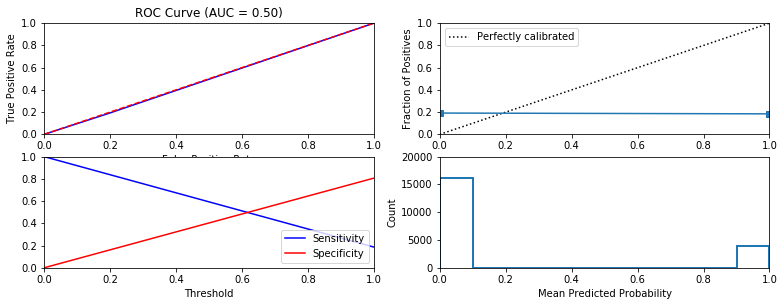


Similarity to LC grade ranking:  -0.00306385368307
Brier score: 0.31165
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[ 0.69513333]


({'model': DummyClassifier(constant=None, random_state=None, strategy='stratified'),
  'y_pred_labels': array([False, False, False, ..., False, False, False], dtype=bool),
  'y_pred_probs': array([0, 0, 0, ..., 0, 0, 0])},
 {'Accuracy': 0.80964999999999998,
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0,
  'roc_auc_score': 0.49641731321736648})

In [19]:
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier()
d,scores = fit_classification(dummy,data_dict,{},'Dummy Classifier',default_seed,True,True)
d,scores

### Naive Bayes

  Model: Gaussian Model
Fit time: 0.05 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 0.9999999999999858
Accuracy:  0.80965
             precision    recall  f1-score   support

 No default     0.8096    1.0000    0.8948     16193
    Default     0.0000    0.0000    0.0000      3807

avg / total     0.6555    0.8096    0.7245     20000



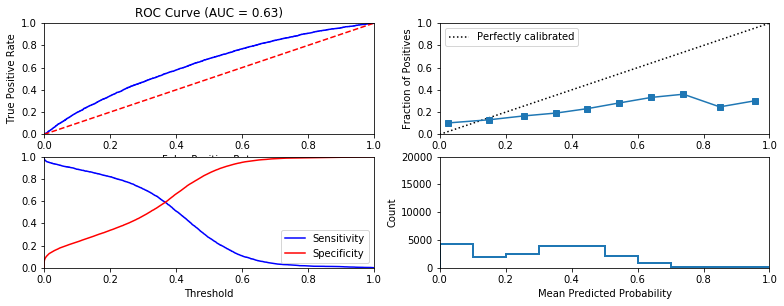


Similarity to LC grade ranking:  0.3238850549174261
Brier score: 0.18358285795668391
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.72593333]


({'model': GaussianNB(priors=None),
  'y_pred_labels': array([False, False, False, ..., False, False, False]),
  'y_pred_probs': array([0.41030916, 0.00272794, 0.58181816, ..., 0.45993004, 0.34670514,
         0.29846877])},
 {'Accuracy': 0.80965,
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0,
  'roc_auc_score': 0.6267209605255597})

In [21]:
data_dict = prepare_data(feature_subset = your_features,random_state=default_seed)
gnb = GaussianNB()
gnb,scores = fit_classification(gnb,data_dict,{},'Gaussian Model',default_seed,True,True)
gnb,scores

### $l_1$ regularized logistic regression

  Model: Logistic Regressoin
Fit time: 13.05 seconds
Optimal parameters:
{'C': 0.1}

Accuracy-maximizing threshold was: 0.4436722063390031
Accuracy:  0.80945
             precision    recall  f1-score   support

 No default     0.8097    0.9995    0.8947     16193
    Default     0.3333    0.0011    0.0021      3807

avg / total     0.7191    0.8095    0.7248     20000



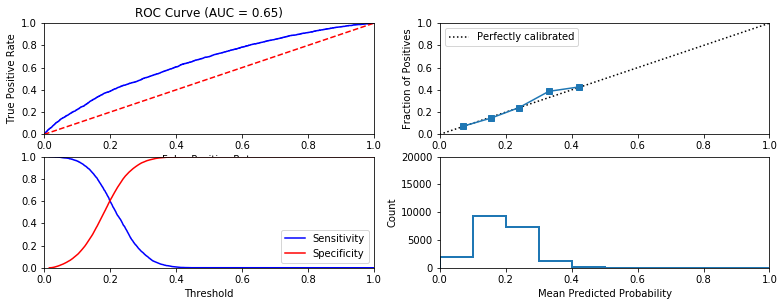


Similarity to LC grade ranking:  0.37360740996654634
Brier score: 0.14769993508230142
Were parameters on edge? : False
Score variations around CV search grid : 0.049396945622190255
[0.80936667 0.80956667 0.80976667 0.80976667]


({'model': LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
            penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
            verbose=0, warm_start=False),
  'y_pred_labels': array([False, False, False, ..., False, False, False]),
  'y_pred_probs': array([0.22387375, 0.08150753, 0.30876177, ..., 0.24119301, 0.13439084,
         0.21346562])},
 {'Accuracy': 0.80945,
  'precision': 0.3333333333333333,
  'recall': 0.0010506960861570791,
  'f1': 0.002094789211835559,
  'roc_auc_score': 0.6470436536063352})

In [20]:
data_dict = prepare_data(feature_subset = your_features,random_state=default_seed)
l1_logistic = LogisticRegression(penalty='l1')
cv_parameters = {'C':[10, 1, .1, .001]}

l1_logistic,scores = fit_classification(l1_logistic,data_dict,cv_parameters,'Logistic Regressoin',
                                 default_seed, True, True)
l1_logistic,scores

### $l_2$ regularized logistic regression

  Model: Logistic Regressoin
Fit time: 1.95 seconds
Optimal parameters:
{'C': 0.1}

Accuracy-maximizing threshold was: 0.4659857967654762
Accuracy:  0.8096
             precision    recall  f1-score   support

 No default     0.8096    0.9999    0.8948     16193
    Default     0.0000    0.0000    0.0000      3807

avg / total     0.6555    0.8096    0.7245     20000



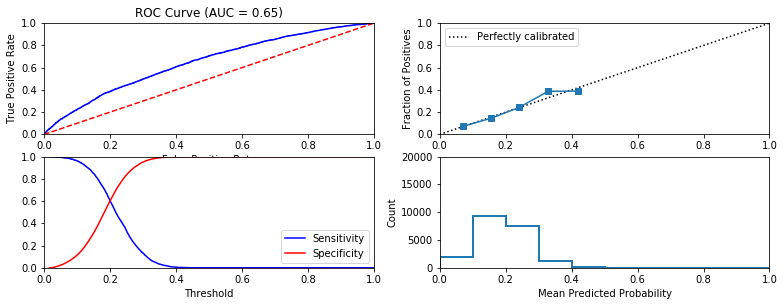


Similarity to LC grade ranking:  0.37635729993243716
Brier score: 0.1477620689535531
Were parameters on edge? : False
Score variations around CV search grid : 0.037047709216642695
[0.80946667 0.80966667 0.80976667 0.80976667]


({'model': LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
            penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
            verbose=0, warm_start=False),
  'y_pred_labels': array([False, False, False, ..., False, False, False]),
  'y_pred_probs': array([0.22755089, 0.08329545, 0.30107648, ..., 0.2385501 , 0.13622292,
         0.21281474])},
 {'Accuracy': 0.8096,
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0,
  'roc_auc_score': 0.6466443949333194})

In [21]:
data_dict = prepare_data(feature_subset = your_features,random_state=default_seed)
l2_logistic = LogisticRegression(penalty='l2')
cv_parameters = {'C':[10, 1, .1, .001]}

l2_logistic,scores = fit_classification(l2_logistic,data_dict,cv_parameters,'Logistic Regressoin',
                                 default_seed, True, True)
l2_logistic,scores

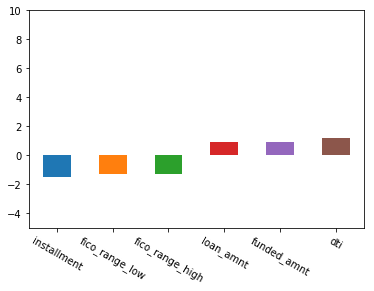

In [22]:
## plot top 3 features with the most positive (and negative) weights 
top_and_bottom_idx = list(np.argsort(l2_logistic['model'].coef_)[0,:3]) + list(np.argsort(l2_logistic['model'].coef_)[0,-3:])
bplot = pd.Series(l2_logistic['model'].coef_[0,top_and_bottom_idx])
xticks = selected_features[top_and_bottom_idx]
p1 = bplot.plot(kind='bar',rot=-30,ylim=(-5,10))
p1.set_xticklabels(xticks)
plt.show()

### Decision tree

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier

  Model: Decision Tree
Fit time: 0.21 seconds
Optimal parameters:
{'max_depth': 3}

Accuracy-maximizing threshold was: 1
Accuracy:  0.80965
             precision    recall  f1-score   support

 No default     0.8096    1.0000    0.8948     16193
    Default     0.0000    0.0000    0.0000      3807

avg / total     0.6555    0.8096    0.7245     20000



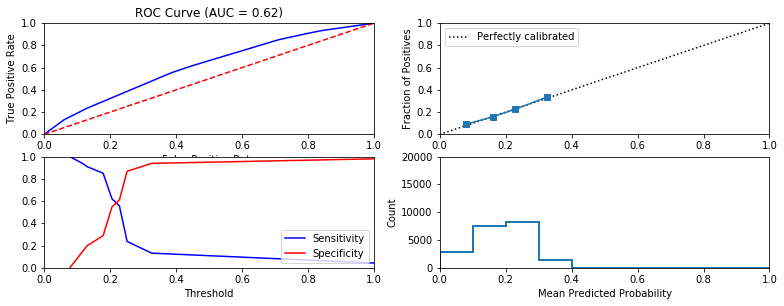


Similarity to LC grade ranking:  0.32315364495517823
Brier score: 0.14991502522046884
Were parameters on edge? : True
Score variations around CV search grid : 0.0
[0.80976667]


({'model': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, presort=False, random_state=None,
              splitter='best'),
  'y_pred_labels': array([False, False, False, ..., False, False, False]),
  'y_pred_probs': array([0.17902472, 0.07812871, 0.22849396, ..., 0.17902472, 0.22849396,
         0.22849396])},
 {'Accuracy': 0.80965,
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0,
  'roc_auc_score': 0.6165232049293239})

In [24]:
data_dict = prepare_data(feature_subset = your_features,random_state=default_seed)
decision_tree = DecisionTreeClassifier()
cv_parameters = {'max_depth':[3]}

decision_tree,scores = fit_classification(decision_tree,data_dict,cv_parameters,
                                   'Decision Tree',default_seed,True,True)
decision_tree,scores

### Random forest

  Model: Random Forest
Fit time: 526.19 seconds
Optimal parameters:
{'max_depth': 7, 'n_estimators': 250}

Accuracy-maximizing threshold was: 0.34331716574698207
Accuracy:  0.80335
              precision    recall  f1-score   support

  No default     0.8126    0.9826    0.8895     16116
     Default     0.4521    0.0595    0.1051      3884

   micro avg     0.8034    0.8034    0.8034     20000
   macro avg     0.6323    0.5211    0.4973     20000
weighted avg     0.7426    0.8034    0.7372     20000



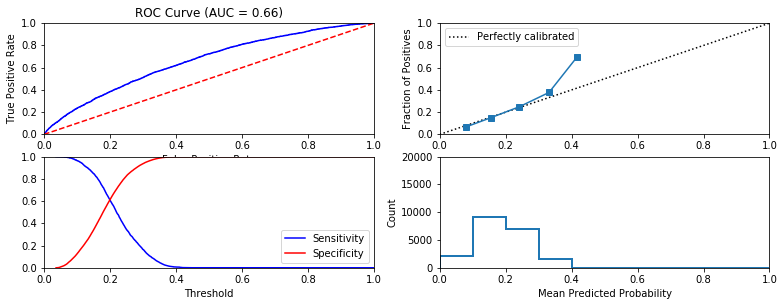


Similarity to LC grade ranking:  0.4059763877986786
Brier score: 0.14886101467313356
Were parameters on edge? : False
Score variations around CV search grid : 0.4617033555940349
[0.80853333 0.80853333 0.80853333 0.80853333 0.80853333 0.80853333
 0.80853333 0.80853333 0.80853333 0.80853333 0.80853333 0.80853333
 0.80853333 0.80853333 0.80853333 0.80853333 0.80853333 0.80853333
 0.80856667 0.80853333 0.80856667 0.80853333 0.8086     0.80856667
 0.8085     0.80846667 0.8086     0.80853333 0.80856667 0.80856667
 0.805      0.80486667 0.80553333 0.80673333 0.80583333 0.8068    ]


{'model': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=7, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=None,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False),
 'y_pred_labels': array([False, False, False, ...,  True, False, False]),
 'y_pred_probs': array([0.14337861, 0.20866997, 0.25396906, ..., 0.35343088, 0.07114237,
        0.2502715 ])}

In [25]:
data_dict = prepare_data(feature_subset = your_features,random_state=default_seed)
random_forest = RandomForestClassifier()
cv_parameters = {'n_estimators':[50, 100, 150, 200, 250, 300],
                'max_depth':[3, 4, 5, 7, 8, None]}

random_forest,scores = fit_classification(random_forest,data_dict,cv_parameters,
                                   'Random Forest',default_seed,True,True)
random_forest,scores

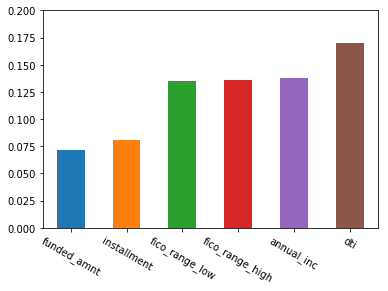

In [26]:
## Plot top 6 most significant features
top_idx = list(np.argsort(random_forest['model'].feature_importances_)[-6:]) 
bplot = pd.Series(random_forest['model'].feature_importances_[top_idx])
xticks = selected_features[top_idx]
p2 = bplot.plot(kind='bar',rot=-30,ylim=(0,0.2))
p2.set_xticklabels(xticks)
plt.show()

### Multi-layer perceptron

  Model: Multi-layer Perceptron
Fit time: 93.68 seconds
Optimal parameters:
{'activation': 'relu', 'hidden_layer_sizes': (50, 50, 50)}

Accuracy-maximizing threshold was: 0.41555652362984413
Accuracy:  0.81025
             precision    recall  f1-score   support

 No default     0.8210    0.9792    0.8931     16193
    Default     0.5087    0.0917    0.1554      3807

avg / total     0.7615    0.8103    0.7527     20000



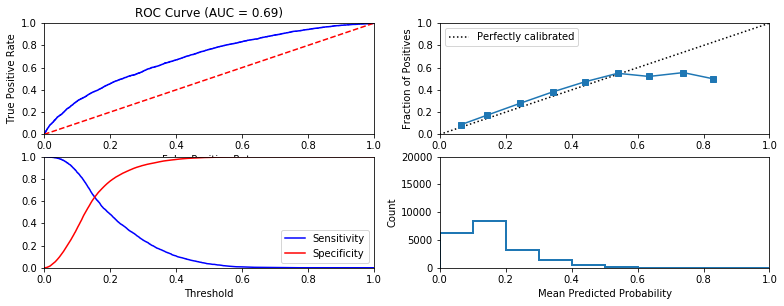


Similarity to LC grade ranking:  0.6161580078999987
Brier score: 0.14284391106322777
Were parameters on edge? : True
Score variations around CV search grid : 0.4156891797341189
[0.80653333 0.80673333 0.80953333 0.8099     0.80973333 0.8097    ]


({'model': MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
         beta_2=0.999, early_stopping=False, epsilon=1e-08,
         hidden_layer_sizes=(50, 50, 50), learning_rate='constant',
         learning_rate_init=0.001, max_iter=200, momentum=0.9,
         nesterovs_momentum=True, power_t=0.5, random_state=None,
         shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
         verbose=False, warm_start=False),
  'y_pred_labels': array([False, False, False, ..., False, False, False]),
  'y_pred_probs': array([0.20655533, 0.03625617, 0.37521499, ..., 0.13083665, 0.1112682 ,
         0.12904969])},
 {'Accuracy': 0.81025,
  'precision': 0.5087463556851312,
  'recall': 0.09167323351720515,
  'f1': 0.15535277097707545,
  'roc_auc_score': 0.6937832619921851})

In [26]:
mlp = MLPClassifier()
cv_parameters = {'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
        'activation': ['tanh', 'relu']}

mlp,scores = fit_classification(mlp,data_dict,cv_parameters,'Multi-layer Perceptron',default_seed, True, True)
mlp,scores

## Running models on Temporal data

In [28]:
data.issue_d = data.issue_d.astype('datetime64[ns]')

## Naive Bayes

  Model: Gaussian Model
Fit time: 0.05 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 1
Accuracy:  0.8037
             precision    recall  f1-score   support

 No default     0.8037    1.0000    0.8912     16074
    Default     0.0000    0.0000    0.0000      3926

avg / total     0.6459    0.8037    0.7162     20000



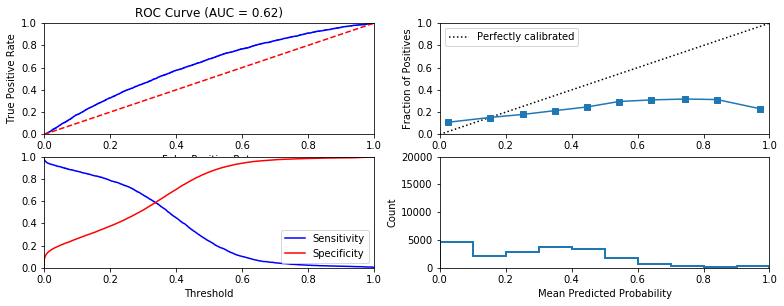


Similarity to LC grade ranking:  0.33178039150140626
Brier score: 0.18662026402020607
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.7488]
{'model': GaussianNB(priors=None), 'y_pred_labels': array([False, False, False, ..., False, False, False]), 'y_pred_probs': array([0.59852796, 0.55125466, 0.62574363, ..., 0.31416277, 0.2751486 ,
       0.42545513])}
{'Accuracy': 0.8037, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'roc_auc_score': 0.619924811577326}


In [29]:
data_dict = prepare_data(feature_subset = your_features, date_range_train = ('2010-01-01', '2015-12-01'),
                    date_range_test = ('2015-12-02','2017-12-01'),random_state=default_seed)

gnb = GaussianNB()
gnb,scores = fit_classification(gnb,data_dict,{},'Gaussian Model',default_seed,True,True)
print(gnb)
print(scores)

### $l_1$ regularized logistic regression

  Model: Logistic Regressoin
Fit time: 4.58 seconds
Optimal parameters:
{'C': 0.001}

Accuracy-maximizing threshold was: 1
Accuracy:  0.8037
             precision    recall  f1-score   support

 No default     0.8037    1.0000    0.8912     16074
    Default     0.0000    0.0000    0.0000      3926

avg / total     0.6459    0.8037    0.7162     20000



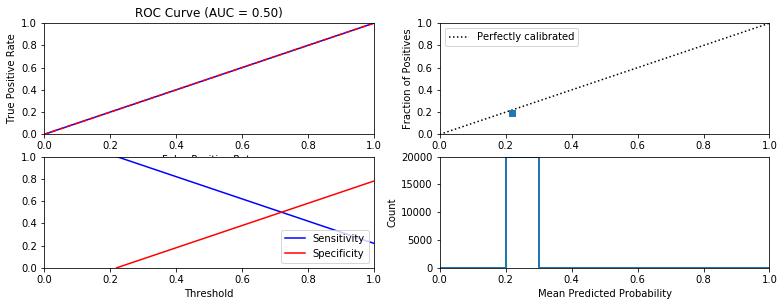


Similarity to LC grade ranking:  nan
Brier score: 0.15834071707066627
Were parameters on edge? : True
Score variations around CV search grid : 0.1024926205313241
[0.81226667 0.81223333 0.81296667 0.81306667]
{'model': LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), 'y_pred_labels': array([False, False, False, ..., False, False, False]), 'y_pred_probs': array([0.22026679, 0.22026679, 0.22026679, ..., 0.22026679, 0.22026679,
       0.22026679])}


{'Accuracy': 0.8037,
 'precision': 0.0,
 'recall': 0.0,
 'f1': 0.0,
 'roc_auc_score': 0.5}

In [30]:
#data_dict = prepare_data(feature_subset = your_features,random_state=default_seed)
l1_logistic = LogisticRegression(penalty='l1')
cv_parameters = {'C':[10, 1, .1, .001]}

l1_logistic,scores = fit_classification(l1_logistic,data_dict,cv_parameters,'Logistic Regressoin',
                                 default_seed, True, True)
print(l1_logistic)
scores

### $l_2$ regularized logistic regression

  Model: Logistic Regressoin
Fit time: 0.87 seconds
Optimal parameters:
{'C': 0.001}

Accuracy-maximizing threshold was: 1
Accuracy:  0.8037
             precision    recall  f1-score   support

 No default     0.8037    1.0000    0.8912     16074
    Default     0.0000    0.0000    0.0000      3926

avg / total     0.6459    0.8037    0.7162     20000



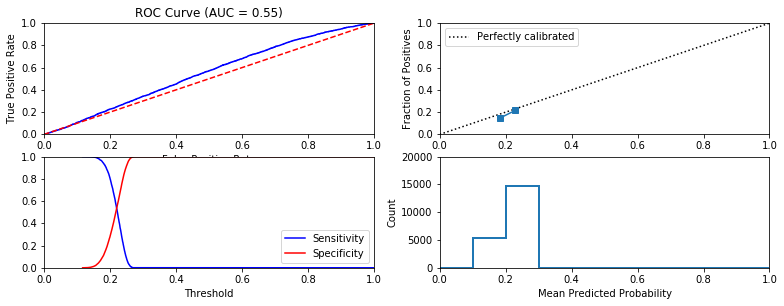


Similarity to LC grade ranking:  0.2096992200534392
Brier score: 0.15728748681371119
Were parameters on edge? : True
Score variations around CV search grid : 0.11069203017382895
[0.81216667 0.81266667 0.81303333 0.81306667]
{'model': LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), 'y_pred_labels': array([False, False, False, ..., False, False, False]), 'y_pred_probs': array([0.25271832, 0.24453511, 0.24804607, ..., 0.1691173 , 0.18417022,
       0.22158455])}


{'Accuracy': 0.8037,
 'precision': 0.0,
 'recall': 0.0,
 'f1': 0.0,
 'roc_auc_score': 0.54986226146761}

In [31]:
l2_logistic = LogisticRegression(penalty='l2')
cv_parameters = {'C':[10, 1, .1, .001]}

l2_logistic,scores = fit_classification(l2_logistic,data_dict,cv_parameters,'Logistic Regressoin',
                                 default_seed, True, True)
print(l2_logistic)
scores

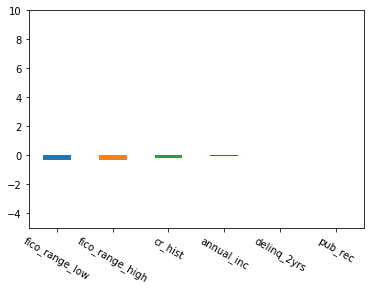

In [32]:
## plot top 3 features with the most positive (and negative) weights 
top_and_bottom_idx = list(np.argsort(l2_logistic['model'].coef_)[0,:3]) + list(np.argsort(l2_logistic['model'].coef_)[0,-3:])
bplot = pd.Series(l2_logistic['model'].coef_[0,top_and_bottom_idx])
xticks = selected_features[top_and_bottom_idx]
p1 = bplot.plot(kind='bar',rot=-30,ylim=(-5,10))
p1.set_xticklabels(xticks)
plt.show()

## Decision Trees

  Model: Decision Tree
Fit time: 0.21 seconds
Optimal parameters:
{'max_depth': 3}

Accuracy-maximizing threshold was: 1
Accuracy:  0.8037
             precision    recall  f1-score   support

 No default     0.8037    1.0000    0.8912     16074
    Default     0.0000    0.0000    0.0000      3926

avg / total     0.6459    0.8037    0.7162     20000



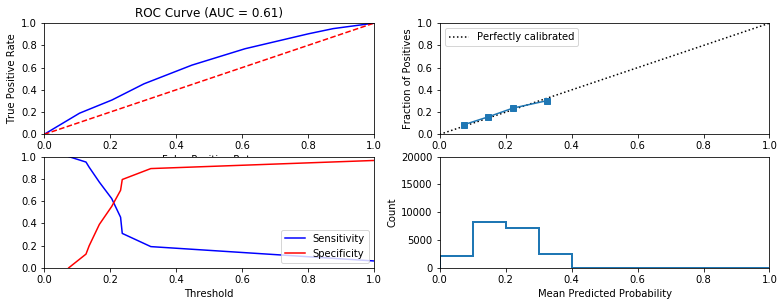


Similarity to LC grade ranking:  0.3504681822355957
Brier score: 0.1539166892518072
Were parameters on edge? : True
Score variations around CV search grid : 0.0
[0.81306667]
{'model': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), 'y_pred_labels': array([False, False, False, ..., False, False, False]), 'y_pred_probs': array([0.16768113, 0.23201621, 0.23201621, ..., 0.2050621 , 0.2050621 ,
       0.2050621 ])}


{'Accuracy': 0.8037,
 'precision': 0.0,
 'recall': 0.0,
 'f1': 0.0,
 'roc_auc_score': 0.6132079624604264}

In [33]:
decision_tree = DecisionTreeClassifier()
cv_parameters = {'max_depth':[3]}

decision_tree,scores = fit_classification(decision_tree,data_dict,cv_parameters,
                                   'Decision Tree',default_seed,True,True)
print(decision_tree)
scores

## Random Forests

  Model: Random Forest
Fit time: 38.88 seconds
Optimal parameters:
{'max_depth': 3, 'n_estimators': 50}

Accuracy-maximizing threshold was: 0.29593450103090324
Accuracy:  0.8036
             precision    recall  f1-score   support

 No default     0.8039    0.9995    0.8911     16074
    Default     0.4286    0.0015    0.0030      3926

avg / total     0.7302    0.8036    0.7168     20000



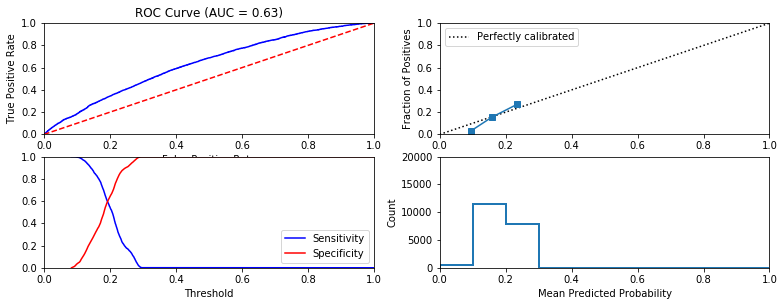


Similarity to LC grade ranking:  0.3771245840490318
Brier score: 0.15304872742025516
Were parameters on edge? : True
Score variations around CV search grid : 0.0
[0.81306667 0.81306667 0.81306667 0.81306667 0.81306667 0.81306667
 0.81306667 0.81306667 0.81306667]


({'model': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=3, max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
              oob_score=False, random_state=None, verbose=0,
              warm_start=False),
  'y_pred_labels': array([False, False, False, ..., False, False, False]),
  'y_pred_probs': array([0.18108057, 0.23124822, 0.23321336, ..., 0.19432023, 0.19616094,
         0.20873781])},
 {'Accuracy': 0.8036,
  'precision': 0.42857142857142855,
  'recall': 0.0015282730514518594,
  'f1': 0.003045685279187817,
  'roc_auc_score': 0.6335754604389239})

In [34]:
random_forest = RandomForestClassifier()
cv_parameters = {'n_estimators':[50, 100, 150],
                'max_depth':[3, 4, 5]}

random_forest,scores = fit_classification(random_forest,data_dict,cv_parameters,
                                   'Random Forest',default_seed,True,True)
random_forest,scores

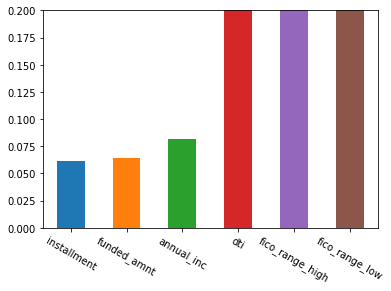

In [35]:
## Plot top 6 most significant features
top_idx = list(np.argsort(random_forest['model'].feature_importances_)[-6:]) 
bplot = pd.Series(random_forest['model'].feature_importances_[top_idx])
xticks = selected_features[top_idx]
p2 = bplot.plot(kind='bar',rot=-30,ylim=(0,0.2))
p2.set_xticklabels(xticks)
plt.show()

## Multi Layer Perceptron

  Model: Multi-layer Perceptron
Fit time: 79.63 seconds
Optimal parameters:
{'activation': 'relu', 'hidden_layer_sizes': (50, 50, 50)}

Accuracy-maximizing threshold was: 0.47079730769983885
Accuracy:  0.8002
             precision    recall  f1-score   support

 No default     0.8143    0.9733    0.8868     16074
    Default     0.4556    0.0914    0.1523      3926

avg / total     0.7439    0.8002    0.7426     20000



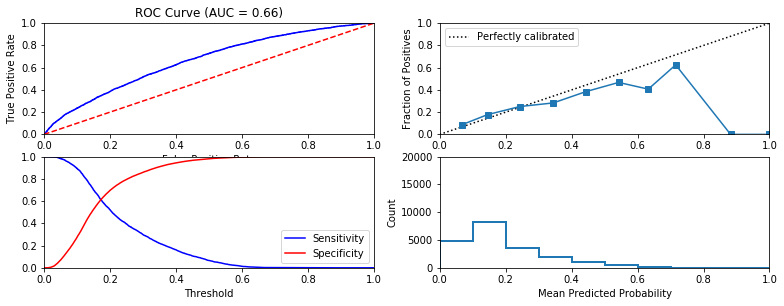


Similarity to LC grade ranking:  0.6319627454221769
Brier score: 0.1508418325409353
Were parameters on edge? : True
Score variations around CV search grid : 0.11477761836441995
[0.81256667 0.81226667 0.81223333 0.81316667 0.81306667 0.81236667]


({'model': MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
         beta_2=0.999, early_stopping=False, epsilon=1e-08,
         hidden_layer_sizes=(50, 50, 50), learning_rate='constant',
         learning_rate_init=0.001, max_iter=200, momentum=0.9,
         nesterovs_momentum=True, power_t=0.5, random_state=None,
         shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
         verbose=False, warm_start=False),
  'y_pred_labels': array([False, False, False, ...,  True, False, False]),
  'y_pred_probs': array([0.08934132, 0.26343731, 0.3021355 , ..., 0.56309478, 0.11782786,
         0.45983605])},
 {'Accuracy': 0.8002,
  'precision': 0.45558375634517767,
  'recall': 0.09144167091186958,
  'f1': 0.15231226134917267,
  'roc_auc_score': 0.6616765328415173})

In [36]:
data_dict = prepare_data(feature_subset = your_features, date_range_train = ('2010-01-01', '2015-12-01'),
                    date_range_test = ('2015-12-02', '2017-12-01'),random_state=default_seed)

mlp = MLPClassifier()
cv_parameters = {'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
        'activation': ['tanh', 'relu']}

mlp,scores = fit_classification(mlp,data_dict,cv_parameters,'Multi-layer Perceptron',default_seed, True, True)
mlp,scores

## Train and Test logistic regression model with features derived by LendingClub

  Model: L1 Logistic Regression
Fit time: 0.86 seconds
Optimal parameters:
{'C': 10}

Accuracy-maximizing threshold was: 0.6331699982229182
Accuracy:  0.8069
              precision    recall  f1-score   support

  No default     0.8068    0.9998    0.8930     16116
     Default     0.8929    0.0064    0.0128      3884

   micro avg     0.8069    0.8069    0.8069     20000
   macro avg     0.8498    0.5031    0.4529     20000
weighted avg     0.8235    0.8069    0.7220     20000



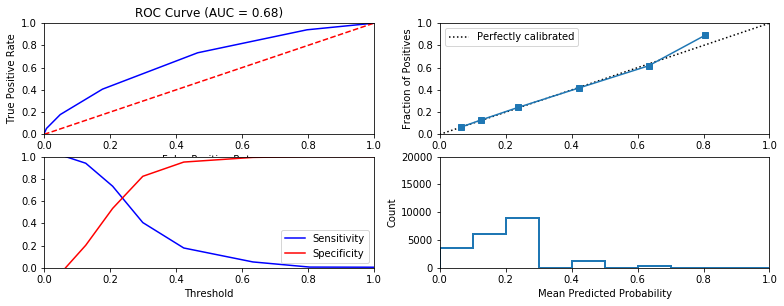


Similarity to LC grade ranking:  0.9999999999999998
Brier score: 0.14439584897705257
Were parameters on edge? : True
Score variations around CV search grid : 0.6023849526697556
[0.81343333 0.81343333 0.8127     0.80853333]


In [28]:
## Find a lendingClub-defined feature and train a l1-regularized logistic regression model on data with only that feature
a_lendingclub_feature = 'grade'

data_dict = prepare_data(feature_subset = a_lendingclub_feature)
lc1_only_logistic = LogisticRegression(penalty='l1')
cv_parameters = {'C':[10, 1, .1, .001]}

lc1_only_logistic = fit_classification(lc1_only_logistic,data_dict,cv_parameters,'L1 Logistic Regression',
                                 default_seed, True, True)

  Model: Logistic Regressoin
Fit time: 0.58 seconds
Optimal parameters:
{'C': 10}

Accuracy-maximizing threshold was: 0.63266666619064
Accuracy:  0.8069
              precision    recall  f1-score   support

  No default     0.8068    0.9998    0.8930     16116
     Default     0.8929    0.0064    0.0128      3884

   micro avg     0.8069    0.8069    0.8069     20000
   macro avg     0.8498    0.5031    0.4529     20000
weighted avg     0.8235    0.8069    0.7220     20000



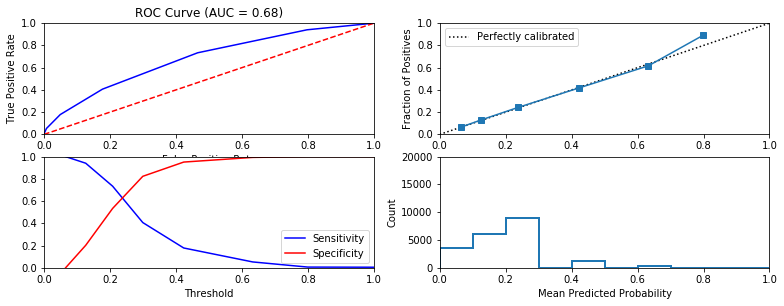


Similarity to LC grade ranking:  0.9999999999999998
Brier score: 0.14439700304789294
Were parameters on edge? : True
Score variations around CV search grid : 0.6023849526697556
[0.81343333 0.81343333 0.81236667 0.80853333]


{'model': LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='warn',
           n_jobs=None, penalty='l2', random_state=None, solver='warn',
           tol=0.0001, verbose=0, warm_start=False),
 'y_pred_labels': array([False, False, False, ..., False, False, False]),
 'y_pred_probs': array([0.12630209, 0.20795408, 0.12630209, ..., 0.20795408, 0.06524071,
        0.12630209])}

In [29]:
## train a l2-regularized logistic regression model on data with only that feature
a_lendingclub_feature = 'grade'

data_dict = prepare_data(feature_subset = a_lendingclub_feature)
l2_logistic = LogisticRegression(penalty='l2')
cv_parameters = {'C':[10, 1, .1, .001]}

l2_logistic,scores = fit_classification(l2_logistic,data_dict,cv_parameters,'Logistic Regressoin',
                                 default_seed, True, True)
l2_logistic

## Train and test all the models you have tried previously after removing features derived by LendingClub 

In [37]:
#removing features derived by lending club
a_lendingclub_feature = ['grade','dti','verification_status','open_acc','installment','delinq_2yrs','revol_bal']
## define your set of features to use in different models
print(discrete_features_dummies)
for s in a_lendingclub_feature:
    sc = [x for x in discrete_features_dummies if x.startswith(s)]
    discrete_features_dummies = list(set(discrete_features_dummies)^set(sc))
discrete_features_dummies
your_features = continuous_features+discrete_features
# prepare the train, test data for training models

all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in your_features]
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)

['home_ownership::MORTGAGE', 'home_ownership::NONE', 'home_ownership::OTHER', 'home_ownership::OWN', 'home_ownership::RENT', 'emp_length::10+ years', 'emp_length::2 years', 'emp_length::3 years', 'emp_length::4 years', 'emp_length::5 years', 'emp_length::6 years', 'emp_length::7 years', 'emp_length::8 years', 'emp_length::9 years', 'emp_length::< 1 year', 'verification_status::Source Verified', 'verification_status::Verified', 'grade::B', 'grade::C', 'grade::D', 'grade::E', 'grade::F', 'grade::G', 'purpose::credit_card', 'purpose::debt_consolidation', 'purpose::educational', 'purpose::home_improvement', 'purpose::house', 'purpose::major_purchase', 'purpose::medical', 'purpose::moving', 'purpose::other', 'purpose::renewable_energy', 'purpose::small_business', 'purpose::vacation', 'purpose::wedding', 'term:: 60 months']


  Model: Gaussian Model
Fit time: 0.12 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 1.0
Accuracy:  0.8058
              precision    recall  f1-score   support

  No default     0.8058    1.0000    0.8925     16116
     Default     0.0000    0.0000    0.0000      3884

   micro avg     0.8058    0.8058    0.8058     20000
   macro avg     0.4029    0.5000    0.4462     20000
weighted avg     0.6493    0.8058    0.7191     20000



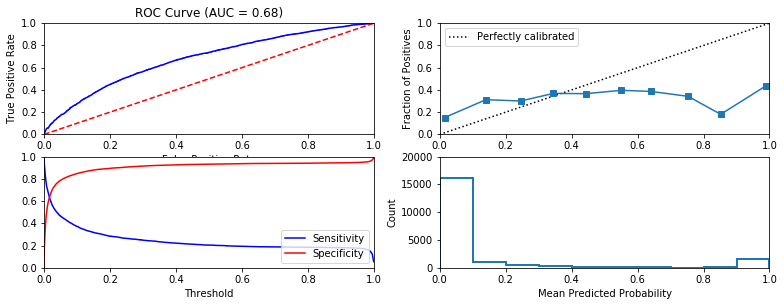


Similarity to LC grade ranking:  0.6295332753975738
Brier score: 0.18994525807844076
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.79043333]


{'model': GaussianNB(priors=None, var_smoothing=1e-09),
 'y_pred_labels': array([False, False, False, ..., False, False, False]),
 'y_pred_probs': array([0.0017922 , 0.0217588 , 0.00062776, ..., 0.17033132, 0.00176573,
        0.02366689])}

In [31]:
data_dict = prepare_data(feature_subset = your_features,random_state=default_seed)
gnb = GaussianNB()
gnb,scores = fit_classification(gnb,data_dict,{},'Gaussian Model',default_seed,True,True)
gnb

## Naive Bayes

In [26]:
## Train and test a naive bayes classifier
import statistics
accuracy = []
precision = []
recall =[]
f1 = []
roc_score = []
for i in range(0,100):
    scores = {}
    data_dict = prepare_data(feature_subset = your_features,random_state=i)
    gnb = GaussianNB()
    gnb,scores = fit_classification(gnb,data_dict,{},'Gaussian Model',i,True,False)
    gnb
    accuracy.append(scores['Accuracy'])
    precision.append(scores['precision'])
    recall.append(scores['recall'])
    f1.append(scores['f1'])
    roc_score.append(scores['roc_auc_score'])
print('Mean accuracy is ', sum(accuracy)/len(accuracy),' with Standard dev ',statistics.stdev(accuracy))
print('Mean precision is ', sum(precision)/len(precision),' with Standard dev ',statistics.stdev(precision))
print('Mean recall is ', sum(recall)/len(recall),' with Standard dev ',statistics.stdev(recall))
print('Mean f1 is ', sum(f1)/len(f1),' with Standard dev ',statistics.stdev(f1))
print('Mean roc_auc_score is ', sum(roc_score)/len(roc_score),' with Standard dev ',statistics.stdev(roc_score))

Mean accuracy is  0.8103080000000001  with Standard dev  0.002523422799742958
Mean precision is  0.020868298368298368  with Standard dev  0.09516524785230356
Mean recall is  4.464720006002855e-05  with Standard dev  0.00020857537296860152
Mean f1 is  8.896806574769205e-05  with Standard dev  0.0004151736973203397
Mean roc_auc_score is  0.6254191384354943  with Standard dev  0.005851798938277963


  Model: Gaussian Model
Fit time: 0.06 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 0.9999964675594276
Accuracy:  0.81015
             precision    recall  f1-score   support

 No default     0.8109    0.9988    0.8951     16217
    Default     0.2308    0.0016    0.0032      3783

avg / total     0.7012    0.8102    0.7264     20000



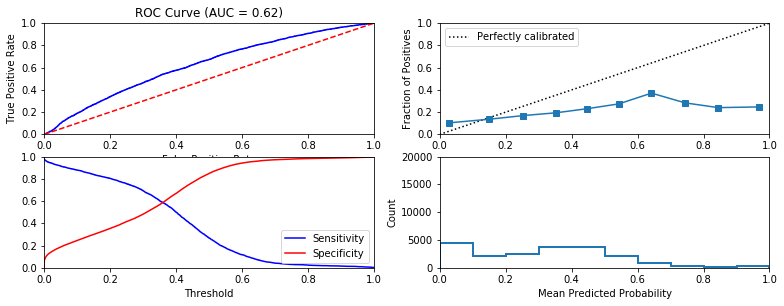


Similarity to LC grade ranking:  0.3078466928402478
Brier score: 0.18655252778477074
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.7399]


({'model': GaussianNB(priors=None),
  'y_pred_labels': array([False, False, False, ..., False, False, False]),
  'y_pred_probs': array([0.32680598, 0.01245875, 0.39000022, ..., 0.46941313, 0.0091645 ,
         0.0007997 ])},
 {'Accuracy': 0.81015,
  'precision': 0.23076923076923078,
  'recall': 0.0015860428231562252,
  'f1': 0.0031504331845628774,
  'roc_auc_score': 0.6234030543753254})

In [27]:
i = f1.index(max(f1))
data_dict = prepare_data(feature_subset = your_features,random_state=i)
gnb = GaussianNB()
gnb,scores = fit_classification(gnb,data_dict,{},'Gaussian Model',i,True,True)
gnb,scores

### $l_1$ regularized logistic regression


In [20]:
import statistics

In [18]:
## Train and test a l_1 regularized logistic regression classifier
accuracy = []
precision = []
recall =[]
f1 = []
roc_score = []
for i in range(0,100):
    data_dict = prepare_data(feature_subset = your_features,random_state=i)
    l1_logistic = LogisticRegression(penalty='l1')
    cv_parameters = {'C':[10, 1, .1, .001]}

    l1_logistic,scores = fit_classification(l1_logistic,data_dict,cv_parameters,'Logistic Regressoin',i, True, False)
    l1_logistic
    accuracy.append(scores['Accuracy'])
    precision.append(scores['precision'])
    recall.append(scores['recall'])
    f1.append(scores['f1'])
    roc_score.append(scores['roc_auc_score'])
print('Mean accuracy is ', sum(accuracy)/len(accuracy),' with Standard dev ',statistics.stdev(accuracy))
print('Mean precision is ', sum(precision)/len(precision),' with Standard dev ',statistics.stdev(precision))
print('Mean recall is ', sum(recall)/len(recall),' with Standard dev ',statistics.stdev(recall))
print('Mean f1 is ', sum(f1)/len(f1),' with Standard dev ',statistics.stdev(f1))
print('Mean roc_auc_score is ', sum(roc_score)/len(roc_score),' with Standard dev ',statistics.stdev(roc_score))

Mean accuracy is  0.808355  with Standard dev  0.0025953430516129266
Mean precision is  0.2040769230769231  with Standard dev  0.25131566872051003
Mean recall is  0.0006738962751649342  with Standard dev  0.001119562435511823
Mean f1 is  0.0013416193116829638  with Standard dev  0.0022253906075754147
Mean roc_auc_score is  0.6013095868192272  with Standard dev  0.06997205790394496


  Model: Logistic Regression
Fit time: 4.67 seconds
Optimal parameters:
{'C': 0.1}

Accuracy-maximizing threshold was: 0.4447889499327625
Accuracy:  0.81035
             precision    recall  f1-score   support

 No default     0.8107    0.9994    0.8952     16214
    Default     0.2308    0.0008    0.0016      3786

avg / total     0.7009    0.8104    0.7261     20000



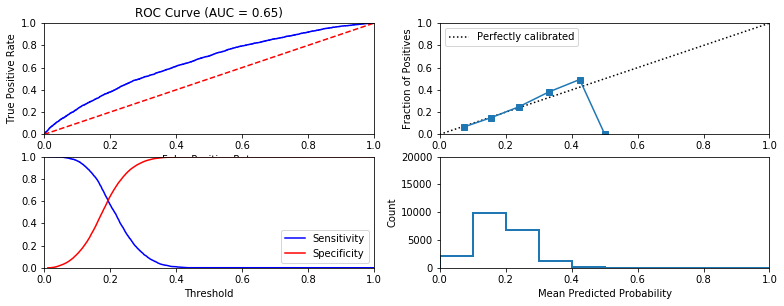


Similarity to LC grade ranking:  0.3684296363674322
Brier score: 0.1467653592687013
Were parameters on edge? : False
Score variations around CV search grid : 0.045120800689112714
[0.81226667 0.81243333 0.81263333 0.81263333]


({'model': LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
            penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
            verbose=0, warm_start=False),
  'y_pred_labels': array([False, False, False, ..., False, False, False]),
  'y_pred_probs': array([0.23748578, 0.20357354, 0.08608104, ..., 0.1258032 , 0.25916412,
         0.19051476])},
 {'Accuracy': 0.81035,
  'precision': 0.23076923076923078,
  'recall': 0.000792393026941363,
  'f1': 0.001579362990260595,
  'roc_auc_score': 0.6509081258714091})

In [30]:
i = f1.index(max(f1))
data_dict = prepare_data(feature_subset = your_features,random_state=i)
cv_parameters = {'C':[10, 1, .1, .001]}
l1_logistic = LogisticRegression(penalty='l1')
l1_logistic,scores = fit_classification(l1_logistic,data_dict,cv_parameters,'Logistic Regression',i, True, True)
l1_logistic,scores

### $l_2$ regularized logistic regression

In [31]:
## Train and test a l_1 regularized logistic regression classifier
accuracy = []
precision = []
recall =[]
f1 = []
roc_score = []
for i in range(0,100):
    data_dict = prepare_data(feature_subset = your_features,random_state=i)
    l2_logistic = LogisticRegression(penalty='l2')
    cv_parameters = {'C':[10, 1, .1, .001]}

    l2_logistic,scores = fit_classification(l2_logistic,data_dict,cv_parameters,'Logistic Regressoin',
                                 i, True, False)
    l2_logistic
    accuracy.append(scores['Accuracy'])
    precision.append(scores['precision'])
    recall.append(scores['recall'])
    f1.append(scores['f1'])
    roc_score.append(scores['roc_auc_score'])
print('Mean accuracy is ', sum(accuracy)/len(accuracy),' with Standard dev ',statistics.stdev(accuracy))
print('Mean precision is ', sum(precision)/len(precision),' with Standard dev ',statistics.stdev(precision))
print('Mean recall is ', sum(recall)/len(recall),' with Standard dev ',statistics.stdev(recall))
print('Mean f1 is ', sum(f1)/len(f1),' with Standard dev ',statistics.stdev(f1))
print('Mean roc_auc_score is ', sum(roc_score)/len(roc_score),' with Standard dev ',statistics.stdev(roc_score))

Mean accuracy is  0.8101994999999999  with Standard dev  0.0025315134511859363
Mean precision is  0.2674468726425584  with Standard dev  0.2252780354477558
Mean recall is  0.0028597167407395352  with Standard dev  0.00404753405744833
Mean f1 is  0.0056186945459571  with Standard dev  0.00789783122756502
Mean roc_auc_score is  0.6327413481998417  with Standard dev  0.035772471491263134


  Model: Logistic Regressoin
Fit time: 0.9 seconds
Optimal parameters:
{'C': 0.1}

Accuracy-maximizing threshold was: 0.3790757269365978
Accuracy:  0.8132
             precision    recall  f1-score   support

 No default     0.8149    0.9965    0.8966     16258
    Default     0.5250    0.0168    0.0326      3742

avg / total     0.7607    0.8132    0.7350     20000



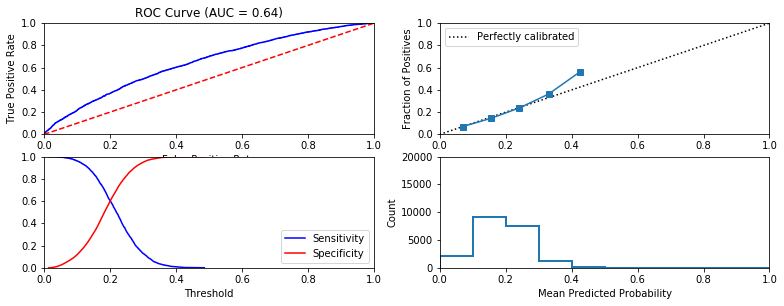


Similarity to LC grade ranking:  0.37657501605427374
Brier score: 0.145945464726541
Were parameters on edge? : False
Score variations around CV search grid : 0.03294214535721276
[0.80923333 0.8093     0.8095     0.8095    ]


({'model': LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
            penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
            verbose=0, warm_start=False),
  'y_pred_labels': array([False, False, False, ..., False, False, False]),
  'y_pred_probs': array([0.08265977, 0.12529566, 0.07556461, ..., 0.18198182, 0.14081761,
         0.15120209])},
 {'Accuracy': 0.8132,
  'precision': 0.525,
  'recall': 0.016835916622127203,
  'f1': 0.03262558259968927,
  'roc_auc_score': 0.644436100167009})

In [32]:
i = f1.index(max(f1))
l2_logistic = LogisticRegression(penalty='l2')
data_dict = prepare_data(feature_subset = your_features,random_state=i)
cv_parameters = {'C':[10, 1, .1, .001]}

l2_logistic,scores = fit_classification(l2_logistic,data_dict,cv_parameters,'Logistic Regressoin',
                                 i, True, True)
l2_logistic,scores

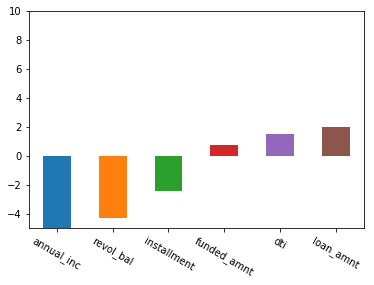

In [22]:
## plot top 3 features with the most positive (and negative) weights 
top_and_bottom_idx = list(np.argsort(l2_logistic['model'].coef_)[0,:3]) + list(np.argsort(l2_logistic['model'].coef_)[0,-3:])
bplot = pd.Series(l2_logistic['model'].coef_[0,top_and_bottom_idx])
xticks = selected_features[top_and_bottom_idx]
p1 = bplot.plot(kind='bar',rot=-30,ylim=(-5,10))
p1.set_xticklabels(xticks)
plt.show()

### Decision trees

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier

In [33]:
## Train and test a decision tree classifier
accuracy = []
precision = []
recall =[]
f1 = []
roc_score = []
for i in range(0,100):
    data_dict = prepare_data(feature_subset = your_features,random_state=i)
    decision_tree = DecisionTreeClassifier()
    cv_parameters = {'max_depth':[3,6]}

    decision_tree,scores = fit_classification(decision_tree,data_dict,cv_parameters,
                                   'Decision Tree',i,True,False)
    decision_tree
    accuracy.append(scores['Accuracy'])
    precision.append(scores['precision'])
    recall.append(scores['recall'])
    f1.append(scores['f1'])
    roc_score.append(scores['roc_auc_score'])
print('Mean accuracy is ', sum(accuracy)/len(accuracy),' with Standard dev ',statistics.stdev(accuracy))
print('Mean precision is ', sum(precision)/len(precision),' with Standard dev ',statistics.stdev(precision))
print('Mean recall is ', sum(recall)/len(recall),' with Standard dev ',statistics.stdev(recall))
print('Mean f1 is ', sum(f1)/len(f1),' with Standard dev ',statistics.stdev(f1))
print('Mean roc_auc_score is ', sum(roc_score)/len(roc_score),' with Standard dev ',statistics.stdev(roc_score))

Mean accuracy is  0.8103210000000002  with Standard dev  0.0025142541115356033
Mean precision is  0.0  with Standard dev  0.0
Mean recall is  0.0  with Standard dev  0.0
Mean f1 is  0.0  with Standard dev  0.0
Mean roc_auc_score is  0.6172060991212084  with Standard dev  0.004734246923315534


  Model: Decision Tree
Fit time: 0.47 seconds
Optimal parameters:
{'max_depth': 3}

Accuracy-maximizing threshold was: 1
Accuracy:  0.8098
             precision    recall  f1-score   support

 No default     0.8098    1.0000    0.8949     16196
    Default     0.0000    0.0000    0.0000      3804

avg / total     0.6558    0.8098    0.7247     20000



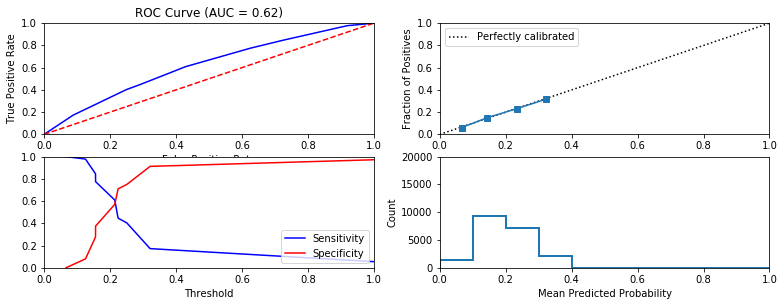


Similarity to LC grade ranking:  0.3265149810520542
Brier score: 0.14974466989841959
Were parameters on edge? : True
Score variations around CV search grid : 0.26340700498002345
[0.8099     0.80776667]


({'model': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, presort=False, random_state=None,
              splitter='best'),
  'y_pred_labels': array([False, False, False, ..., False, False, False]),
  'y_pred_probs': array([0.25114826, 0.06646372, 0.1256621 , ..., 0.15623337, 0.25114826,
         0.1256621 ])},
 {'Accuracy': 0.8098,
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0,
  'roc_auc_score': 0.6182265002795668})

In [34]:
i = f1.index(max(f1))
decision_tree = DecisionTreeClassifier()
data_dict = prepare_data(feature_subset = your_features,random_state=i)
cv_parameters = {'max_depth':[3,6]}

decision_tree,scores = fit_classification(decision_tree,data_dict,cv_parameters,
                                   'Decision Tree',i,True,True)
decision_tree,scores

### Random forests

In [39]:
## Train and test a random forest classifier
accuracy = []
precision = []
recall =[]
f1 = []
roc_score = []
for i in range(0,100):
    data_dict = prepare_data(feature_subset = your_features,random_state=i)
    random_forest = RandomForestClassifier()
    cv_parameters = {'n_estimators':[50, 100, 150],
                'max_depth':[3, 4, 5]}

    random_forest,scores = fit_classification(random_forest,data_dict,cv_parameters,
                                   'Random Forest',i,True,False)
    random_forest
    accuracy.append(scores['Accuracy'])
    precision.append(scores['precision'])
    recall.append(scores['recall'])
    f1.append(scores['f1'])
    roc_score.append(scores['roc_auc_score'])
print('Mean accuracy is ', sum(accuracy)/len(accuracy),' with Standard dev ',statistics.stdev(accuracy))
print('Mean precision is ', sum(precision)/len(precision),' with Standard dev ',statistics.stdev(precision))
print('Mean recall is ', sum(recall)/len(recall),' with Standard dev ',statistics.stdev(recall))
print('Mean f1 is ', sum(f1)/len(f1),' with Standard dev ',statistics.stdev(f1))
print('Mean roc_auc_score is ', sum(roc_score)/len(roc_score),' with Standard dev ',statistics.stdev(roc_score))

Mean accuracy is  0.8101460000000003  with Standard dev  0.0025097253260309605
Mean precision is  0.4458606680489959  with Standard dev  0.16436147684267682
Mean recall is  0.006097132933303503  with Standard dev  0.005665707607307716
Mean f1 is  0.011905243484781301  with Standard dev  0.010829324589125928
Mean roc_auc_score is  0.6422946438592269  with Standard dev  0.004569362160254179


In [41]:
i = f1.index(max(f1))
data_dict = prepare_data(feature_subset = your_features,random_state=i)
random_forest = RandomForestClassifier()
cv_parameters = {'n_estimators':[50, 100, 150],
                'max_depth':[3, 4, 5]}

random_forest,scores = fit_classification(random_forest,data_dict,cv_parameters,
                                   'Random Forest',i,True,False)
random_forest,scores

({'model': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=5, max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
              oob_score=False, random_state=None, verbose=0,
              warm_start=False),
  'y_pred_labels': array([False, False, False, ..., False, False, False]),
  'y_pred_probs': array([0.13500249, 0.15213821, 0.17892436, ..., 0.23451928, 0.0846881 ,
         0.08755646])},
 {'Accuracy': 0.80505,
  'precision': 0.45228215767634855,
  'recall': 0.028121775025799794,
  'f1': 0.05295117804226379,
  'roc_auc_score': 0.6560901593660483})

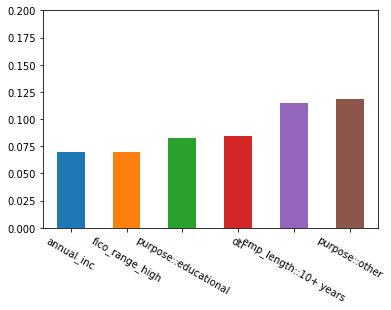

In [39]:
## Plot top 6 most significant features
top_idx = list(np.argsort(random_forest['model'].feature_importances_)[-6:]) 
bplot = pd.Series(random_forest['model'].feature_importances_[top_idx])
xticks = selected_features[top_idx]
p2 = bplot.plot(kind='bar',rot=-30,ylim=(0,0.2))
p2.set_xticklabels(xticks)
plt.show()

### Multi-layer perceptron

In [37]:
## Train and test a multi-layer perceptron classifier
accuracy = []
precision = []
recall =[]
f1 = []
roc_score = []
for i in range(0,100):
    data_dict = prepare_data(feature_subset = your_features,random_state=i)
    mlp = MLPClassifier()
    cv_parameters = {'hidden_layer_sizes': [(50,50,50), (100,)],
        'activation': ['tanh', 'relu']}

    mlp,scores = fit_classification(mlp,data_dict,cv_parameters,'Multi-layer Perceptron',i, True, False)
    accuracy.append(scores['Accuracy'])
    precision.append(scores['precision'])
    recall.append(scores['recall'])
    f1.append(scores['f1'])
    roc_score.append(scores['roc_auc_score'])
print('Mean accuracy is ', sum(accuracy)/len(accuracy),' with Standard dev ',statistics.stdev(accuracy))
print('Mean precision is ', sum(precision)/len(precision),' with Standard dev ',statistics.stdev(precision))
print('Mean recall is ', sum(recall)/len(recall),' with Standard dev ',statistics.stdev(recall))
print('Mean f1 is ', sum(f1)/len(f1),' with Standard dev ',statistics.stdev(f1))
print('Mean roc_auc_score is ', sum(roc_score)/len(roc_score),' with Standard dev ',statistics.stdev(roc_score))

Mean accuracy is  0.8081700000000002  with Standard dev  0.002478036857406817
Mean precision is  0.36523078631920064  with Standard dev  0.18311146070623877
Mean recall is  0.005592658210343695  with Standard dev  0.0064567334914030945
Mean f1 is  0.010907229735223725  with Standard dev  0.012469378397197861
Mean roc_auc_score is  0.655968809383021  with Standard dev  0.006451145049930635


  Model: Multi-layer Perceptron
Fit time: 98.85 seconds
Optimal parameters:
{'activation': 'relu', 'hidden_layer_sizes': (50, 50, 50)}

Accuracy-maximizing threshold was: 0.5389291592606642
Accuracy:  0.8093
             precision    recall  f1-score   support

 No default     0.8142    0.9889    0.8931     16111
    Default     0.5866    0.0653    0.1175      3889

avg / total     0.7700    0.8093    0.7423     20000



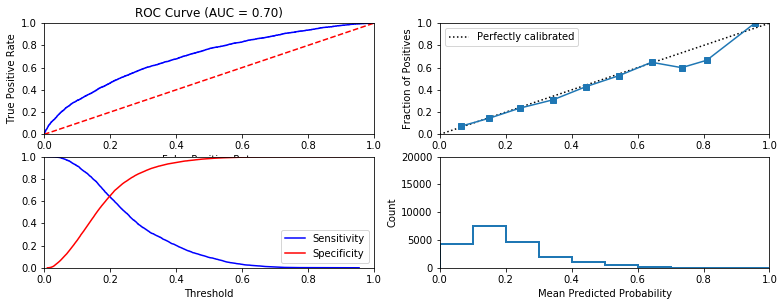


Similarity to LC grade ranking:  0.5977354031074048
Brier score: 0.14307938221730254
Were parameters on edge? : True
Score variations around CV search grid : 0.028846946344676622
[0.80873333 0.80863333 0.8087     0.80886667 0.80886667 0.80866667]


({'model': MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
         beta_2=0.999, early_stopping=False, epsilon=1e-08,
         hidden_layer_sizes=(50, 50, 50), learning_rate='constant',
         learning_rate_init=0.001, max_iter=200, momentum=0.9,
         nesterovs_momentum=True, power_t=0.5, random_state=None,
         shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
         verbose=False, warm_start=False),
  'y_pred_labels': array([False, False, False, ..., False, False, False]),
  'y_pred_probs': array([0.03829879, 0.06520432, 0.13635812, ..., 0.13047235, 0.05820898,
         0.17444188])},
 {'Accuracy': 0.8093,
  'precision': 0.5866050808314087,
  'recall': 0.065312419645153,
  'f1': 0.1175381767700139,
  'roc_auc_score': 0.6984469037515338})

In [38]:
i = f1.index(max(f1))
data_dict = prepare_data(feature_subset = your_features,random_state=i)
mlp = MLPClassifier()
cv_parameters = {'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
        'activation': ['tanh', 'relu']}
mlp,scores = fit_classification(mlp,data_dict,cv_parameters,'Multi-layer Perceptron',i, True, True)
mlp,scores

## Your Model

In [47]:
YourModel = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=5, max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
              oob_score=False, random_state=None, verbose=0,
              warm_start=False)

  Model: Random Forest
Fit time: 10.44 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 0.34514423517522974
Accuracy:  0.8092
             precision    recall  f1-score   support

 No default     0.8126    0.9935    0.8940     16200
    Default     0.4588    0.0234    0.0446      3800

avg / total     0.7454    0.8092    0.7326     20000



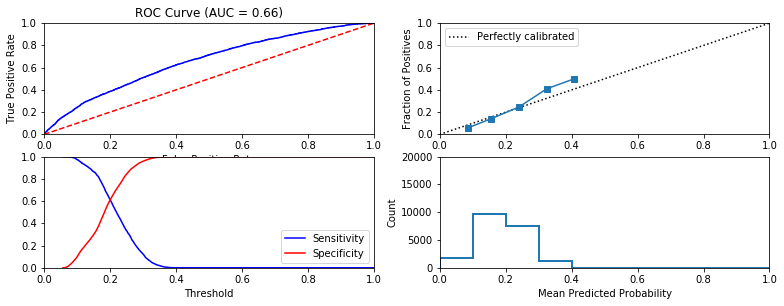


Similarity to LC grade ranking:  0.3806891105386587
Brier score: 0.1469554241899691
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.80816667]


({'model': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=5, max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
              oob_score=False, random_state=None, verbose=0,
              warm_start=False),
  'y_pred_labels': array([False, False, False, ..., False, False, False]),
  'y_pred_probs': array([0.10325359, 0.23949489, 0.27354458, ..., 0.1833768 , 0.11529928,
         0.18188293])},
 {'Accuracy': 0.8092,
  'precision': 0.4587628865979381,
  'recall': 0.023421052631578947,
  'f1': 0.04456685027541312,
  'roc_auc_score': 0.6562590318388564})

In [48]:
random_forest,scores = fit_classification(YourModel,data_dict,cv_parameters={},
                                   model_name = 'Random Forest',random_state = default_seed)
random_forest,scores

## Time stability test of YOURMODEL

  Model: Random Forest
Fit time: 3.87 seconds
Optimal parameters:
{'max_depth': 3, 'n_estimators': 50}

Accuracy-maximizing threshold was: 0.17451928071472875
Accuracy:  0.7821428571428571
             precision    recall  f1-score   support

 No default     0.8909    0.8604    0.8754      6226
    Default     0.1196    0.1525    0.1340       774

avg / total     0.8056    0.7821    0.7934      7000



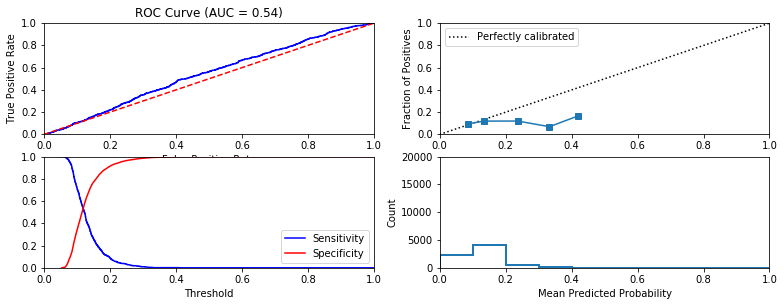


Similarity to LC grade ranking:  0.04068800935756399
Brier score: 0.10041233004123157
Were parameters on edge? : True
Score variations around CV search grid : 0.9803921568627527
[0.88503254 0.88503254 0.88503254 0.88286334 0.88286334 0.88286334
 0.87635575 0.88286334 0.88286334]


({'model': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=3, max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
              oob_score=False, random_state=None, verbose=0,
              warm_start=False),
  'y_pred_labels': array([False, False, False, ..., False,  True, False]),
  'y_pred_probs': array([0.06713238, 0.10009195, 0.07755223, ..., 0.0956777 , 0.23124511,
         0.0978218 ])},
 {'Accuracy': 0.7821428571428571,
  'precision': 0.11955420466058764,
  'recall': 0.1524547803617571,
  'f1': 0.1340147643384441,
  'roc_auc_score': 0.541346574463511})

In [20]:
## Define the time window of your train and test data
start_date_train = datetime.date(2010,1,1)
end_date_train = datetime.date(2010,12,31)
start_date_test = datetime.date(2017,1,1)
end_date_test = datetime.date(2017,12,1)

data_dict_test = prepare_data(date_range_train = (start_date_train, end_date_train), 
                         date_range_test = (start_date_test, end_date_test),
                         n_samples_train = 9000, n_samples_test = 7000, feature_subset = your_features)

## Train and test YOURMODEL using this data
random_forest = RandomForestClassifier()
cv_parameters = {'n_estimators':[50, 100, 150],
                'max_depth':[3, 4, 5]}

random_forest,scores = fit_classification(random_forest,data_dict_test,cv_parameters,'Random Forest',default_seed,True,True)

random_forest,scores

# model, data_dict,
#                           cv_parameters = {},
#                           model_name = None,
#                           random_state = default_seed,
#                           output_to_file = True,
#                           print_to_screen = True

  Model: Random Forest
Fit time: 13.76 seconds
Optimal parameters:
{'max_depth': 3, 'n_estimators': 50}

Accuracy-maximizing threshold was: 0.3321766406291428
Accuracy:  0.8817142857142857
             precision    recall  f1-score   support

 No default     0.8866    0.9934    0.9369      6192
    Default     0.3387    0.0260    0.0483       808

avg / total     0.8233    0.8817    0.8344      7000



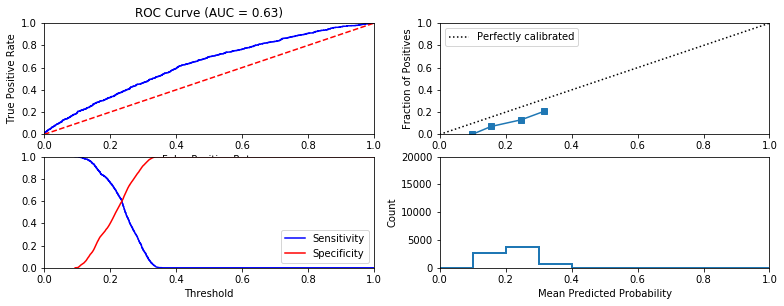


Similarity to LC grade ranking:  0.3392720914582563
Brier score: 0.11091842246385486
Were parameters on edge? : True
Score variations around CV search grid : 0.028756290438535052
[0.77277778 0.77277778 0.77277778 0.77277778 0.77277778 0.77277778
 0.77255556 0.77277778 0.77277778]


({'model': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=3, max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
              oob_score=False, random_state=None, verbose=0,
              warm_start=False),
  'y_pred_labels': array([False, False, False, ..., False, False, False]),
  'y_pred_probs': array([0.15484228, 0.20507051, 0.19145278, ..., 0.3116528 , 0.28042017,
         0.27528776])},
 {'Accuracy': 0.8817142857142857,
  'precision': 0.3387096774193548,
  'recall': 0.02599009900990099,
  'f1': 0.04827586206896552,
  'roc_auc_score': 0.6282095869470669})

In [21]:
## Define the time window of your train and test data
start_date_train = datetime.date(2016,1,1)
end_date_train = datetime.date(2016,12,31)
start_date_test = datetime.date(2017,1,1)
end_date_test = datetime.date(2017,12,1)

data_dict_test = prepare_data(date_range_train = (start_date_train, end_date_train), 
                         date_range_test = (start_date_test, end_date_test),
                         n_samples_train = 9000, n_samples_test = 7000, feature_subset = your_features)

## Train and test YOURMODEL using this data
random_forest = RandomForestClassifier()
cv_parameters = {'n_estimators':[50, 100, 150],
                'max_depth':[3, 4, 5]}

random_forest,scores = fit_classification(random_forest,data_dict_test,cv_parameters,'Random Forest',default_seed,True,True)

random_forest,scores

## Train and test YOURMODEL on the original data

In [71]:
raw_data, discrete_features, continuous_features = pickle.load( open( "raw_data.pickle", "rb" ) )

In [72]:
## Create the outcome columns: True if loan_status is either Charged Off or Default, False otherwise
raw_data["outcome"] = np.where(raw_data.loan_status.isin(['Charged Off','Default']),True,False)

In [73]:
# Randomly assign each row to a training and test set. We do this now because we will be fitting a variety of models on various time periods, and we would like every period to use the *same* training/test split
np.random.seed(default_seed)
## create the train columns where the value is True if it is a train instance and False otherwise. Hint: use np.random.choice with 70% for training and 30% for testing
p=[0.3,0.7]
raw_data['train'] = np.random.choice(len(p),len(raw_data),p=p)
raw_data.train.value_counts()

1    1234965
0     530461
Name: train, dtype: int64

In [74]:
raw_data.dropna(axis=0, how='any', thresh=None, subset=['dti','delinq_2yrs','earliest_cr_line','open_acc','pub_rec','revol_util','last_pymnt_d'], inplace=True)

In [75]:
# Create a matrix of features and outcomes, with dummies. Record the names of the dummies for later use
X_continuous = raw_data[continuous_features].values

X_discrete = pd.get_dummies(raw_data[discrete_features], dummy_na = True, 
                            prefix_sep = "::", drop_first = True)

discrete_features_dummies = X_discrete.columns.tolist()

X_discrete = X_discrete.values

X = np.concatenate( (X_continuous, X_discrete), axis = 1 )

y = raw_data.outcome.values

train = raw_data.train.values

In [76]:
all_col = continuous_features + discrete_features_dummies

df = pd.DataFrame(X,y,columns=all_col)

df = df.reset_index()

df.drop(columns=['index'], inplace = True)

columns_to_remove = ['home_ownership::nan','purpose::nan',
                     'emp_length::nan','verification_status::nan',
                     'term::nan','grade::nan']

df.drop(columns=columns_to_remove, inplace = True)

#Scaling the dataset
data_scaled = (df - df.mean()) / (df.std())

#Updating the discrete_features
for x in columns_to_remove:
    discrete_features_dummies.remove(x)

In [77]:
## define your set of features to use in different models
your_features = continuous_features+discrete_features_dummies

# prepare the train, test data for training models

all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in your_features]
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)

In [78]:
def prepare_data_raw(data_subset = np.array([True]*len(raw_data)),
                    n_samples_train = 30000,
                    n_samples_test = 20000,
                    feature_subset = None,
                    date_range_train = (datetime.date(2007, 6, 1), datetime.date(2017, 12, 1)),
                    date_range_test = (datetime.date(2007, 6, 1), datetime.date(2017, 12, 1)),
                    random_state = default_seed):
    '''
    This function will prepare the data for classification or regression.
    It expects the following parameters:
      - data_subset: a numpy array with as many entries as rows in the
                     dataset. Each entry should be True if that row
                     should be used, or False if it should be ignored
      - n_samples_train: the total number of samples to be used for training.
                         Will trigger an error if this number is larger than
                         the number of rows available after all filters have
                         been applied
      - n_samples_test: as above for testing
      - feature_subect: A list containing the names of the features to be
                        used in the model. In None, all features in X are
                        used
      - date_range_train: a tuple containing two dates. All rows with loans
                          issued outside of these two dates will be ignored in
                          training
      - date_range_test: as above for testing
      - random_state: the random seed to use when selecting a subset of rows
      
    Note that this function assumes the data has a "Train" column, and will
    select all training rows from the rows with "True" in that column, and all
    the testing rows from those with a "False" in that column.
    
    This function returns a dictionary with the following entries
      - X_train: the matrix of training data
      - y_train: the array of training labels
      - train_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the train set
      - X_test: the matrix of testing data
      - y_test: the array of testing labels
      - test_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the test set
    '''
    
    np.random.seed(random_state)
        
    # Filter down the data to the required date range, and downsample
    # as required
    filter_train = ( train & (raw_data.issue_d >= date_range_train[0]) &
                            (raw_data.issue_d <= date_range_train[1]) & data_subset ).values
    filter_test = ( (train == False) & (raw_data.issue_d >= date_range_test[0])
                            & (raw_data.issue_d <= date_range_test[1]) & data_subset ).values
    
    filter_train[ np.random.choice( np.where(filter_train)[0], size = filter_train.sum()
                                                   - n_samples_train, replace = False ) ] = False
    filter_test[ np.random.choice( np.where(filter_test)[0], size = filter_test.sum()
                                                   - n_samples_test, replace = False ) ] = False
    
    # Prepare the training and test set
    X_train = X[ filter_train , :]
    X_test = X[ filter_test, :]
    if feature_subset != None:
        cols = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in feature_subset]
        X_train = X_train[ : , cols ]
        X_test = X_test[ : , cols ]
        
    y_train = y[ filter_train ]
    y_test = y[ filter_test ]
    
    # Scale the variables
    scaler = preprocessing.MinMaxScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # return training and testing data
    out = {'X_train':X_train, 'y_train':y_train, 'train_set':filter_train, 
           'X_test':X_test, 'y_test':y_test, 'test_set':filter_test}
    
    return out

In [79]:
def fit_classification_raw(model, data_dict,
                          cv_parameters = {},
                          model_name = None,
                          random_state = default_seed,
                          output_to_file = True,
                          print_to_screen = True):
    '''
    This function will fit a classification model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    If the model provided does not have a predict_proba function, we will
    simply print accuracy diagnostics and return.
    
    If the model provided does have a predict_proba function, we first
    figure out the optimal threshold that maximizes the accuracy and
    print out accuracy diagnostics. We then print an ROC curve, sensitivity/
    specificity curve, and calibration curve.
    
    This function returns a dictionary with the following entries
      - model: the best fitted model
      - y_pred: predictions for the test set
      - y_pred_probs: probability predictions for the test set, if the model
                      supports them
      - y_pred_score: prediction scores for the test set, if the model does not 
                      output probabilities.
    '''
        
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    X_train = data_dict['X_train']
    y_train = data_dict['y_train']
    
    X_test = data_dict['X_test']
    y_test = data_dict['y_test']
    
    filter_train = data_dict['train_set']    
  
    # --------------------------
    #   Step 2 - Fit the model
    # --------------------------

    cv_model = GridSearchCV(model, cv_parameters)
    
    start_time = time.time()
    cv_model.fit(X_train, y_train)
    end_time = time.time()
    
    best_model = cv_model.best_estimator_
    
    if print_to_screen:

        if model_name != None:
            print("=========================================================")
            print("  Model: " + model_name)
            print("=========================================================")

        print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
        print("Optimal parameters:")
        print(cv_model.best_params_)
        print("")
    
    # -------------------------------
    #   Step 3 - Evaluate the model
    # -------------------------------
    
    # If possible, make probability predictions
    try:
        y_pred_probs = best_model.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
        
        probs_predicted = True
    except:
        probs_predicted = False
    
    # Make predictions; if we were able to find probabilities, use
    # the threshold that maximizes the accuracy in the training set.
    # If not, just use the learner's predict function
    if probs_predicted:
        y_train_pred_probs = best_model.predict_proba(X_train)[:,1]
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_probs)
        
        true_pos_train = tpr_train*(y_train.sum())
        true_neg_train = (1 - fpr_train) *(1-y_train).sum()
        
        best_threshold_index = np.argmax(true_pos_train + true_neg_train)
        best_threshold = 1 if best_threshold_index == 0 else thresholds_train[ best_threshold_index ]
        
        if print_to_screen:
            print("Accuracy-maximizing threshold was: " + str(best_threshold))
        
        y_pred = (y_pred_probs > best_threshold)
    else:
        y_pred = best_model.predict(X_test)
    scores = {}
    if print_to_screen:
        print("Accuracy: ", accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred, target_names =['No default', 'Default'], digits = 4))
    scores['Accuracy'] = accuracy_score(y_test, y_pred)
    scores['precision'] = precision_score(y_test, y_pred)
    scores['recall'] = recall_score(y_test, y_pred)
    scores['f1'] = f1_score(y_test, y_pred)
    scores['roc_auc_score'] = roc_auc_score(y_test, y_pred_probs)
    if print_to_screen:
        if probs_predicted:        
            plt.figure(figsize = (13, 4.5))
            plt.subplot(2, 2, 1)

            plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, y_pred_probs))
            plt.plot(fpr, tpr, 'b')
            plt.plot([0,1],[0,1],'r--')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')

            plt.subplot(2, 2, 3)

            plt.plot(thresholds, tpr, 'b', label = 'Sensitivity')
            plt.plot(thresholds, 1 -fpr, 'r', label = 'Specificity')
            plt.legend(loc = 'lower right')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.xlabel('Threshold')

            plt.subplot(2, 2, 2)

            fp_0, mpv_0 = calibration_curve(y_test, y_pred_probs, n_bins = 10)
            plt.plot([0,1], [0,1], 'k:', label='Perfectly calibrated')
            plt.plot(mpv_0, fp_0, 's-')
            plt.ylabel('Fraction of Positives')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.legend(loc ='upper left')
            
            plt.subplot(2, 2, 4)
            plt.hist(y_pred_probs, range=(0, 1), bins=10, histtype="step", lw=2)
            plt.xlim([0,1]); plt.ylim([0,20000])
            plt.xlabel('Mean Predicted Probability')
            plt.ylabel('Count')
            
            #plt.tight_layout()
            plt.show()
        
    # Additional Score Check
    if probs_predicted:
        y_train_score = y_train_pred_probs
    else:
        y_train_score = best_model.decision_function(X_train)
        
    tau, p_value = kendalltau(y_train_score, raw_data.grade[filter_train])
    if print_to_screen:
        print("")
        print("Similarity to LC grade ranking: ", tau)
    
    if probs_predicted:
        brier_score = brier_score_loss(y_test, y_pred_probs)
        if print_to_screen:
            print("Brier score:", brier_score)
    
    # Return the model predictions, and the
    # test set
    # -------------------------------------
    out = {'model':best_model, 'y_pred_labels':y_pred}
    
    if probs_predicted:
        out.update({'y_pred_probs':y_pred_probs})
    else:
        y_pred_score = best_model.decision_function(X_test)
        out.update({'y_pred_score':y_pred_score})
        
    # Output results to file
    # ----------------------
    if probs_predicted and output_to_file:
        # Check whether any of the CV parameters are on the edge of
        # the search space
        opt_params_on_edge = find_opt_params_on_edge(cv_model)
        dump_to_output(model_name + "::search_on_edge", opt_params_on_edge)
        if print_to_screen:
            print("Were parameters on edge? : " + str(opt_params_on_edge))
        
        # Find out how different the scores are for the different values
        # tested for by cross-validation. If they're not too different, then
        # even if the parameters are off the edge of the search grid, we should
        # be ok
        score_variation = find_score_variation(cv_model)
        dump_to_output(model_name + "::score_variation", score_variation)
        if print_to_screen:
            print("Score variations around CV search grid : " + str(score_variation))
        
        # Print out all the scores
        dump_to_output(model_name + "::all_cv_scores", str(cv_model.cv_results_['mean_test_score']))
        if print_to_screen:
            print( str(cv_model.cv_results_['mean_test_score']) )
        
        # Dump the AUC to file
        dump_to_output(model_name + "::roc_auc", roc_auc_score(y_test, y_pred_probs) )
        
    return out,scores

In [80]:
# Create a matrix of features and outcomes, with dummies. Record the names of the dummies for later use
X_continuous = df[continuous_features].values

X_discrete = df[discrete_features_dummies].values

X = np.concatenate( (X_continuous, X_discrete), axis = 1 )

y = raw_data.outcome.values

train = raw_data.train.values

In [81]:
## define your set of features to use in different models
your_features = continuous_features+discrete_features_dummies

# prepare the train, test data for training models

all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in your_features]
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)

In [152]:
raw_data.issue_d.min()
raw_data.issue_d.max()

datetime.date(2017, 12, 1)

In [46]:
data_dict = prepare_data_raw(data_subset = np.array([True]*len(raw_data)), feature_subset = your_features,random_state=default_seed)
#random_forest = RandomForestClassifier()

random_forest,scores = fit_classification(YourModel,data_dict,cv_parameters={},
                                   model_name = 'Random Forest',random_state = default_seed)
random_forest,scores

NameError: name 'prepare_data_raw' is not defined

## Test regression models

In [49]:
def fit_regression(model, data_dict,
                      cv_parameters = {},
                      separate = False, 
                      model_name = None,
                      random_state = default_seed,
                      output_to_file = True,
                      print_to_screen = True):
    '''
    This function will fit a regression model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - separate: a Boolean variable indicating whether we fit models for 
                  defaulted and non-defaulted loans separately
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over      
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    This function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - model: the best fitted model
      - predicted_return: prediction result based on the test set
      - predicted_regular_return: prediction result for non-defaulted loans (valid if separate == True)
      - predicted_default_return: prediction result for defaulted loans (valid if separate == True)
      - r2_scores: the testing r2_score(s) for the best fitted model
    '''
    
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    
    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
    
    X_train = data_dict['X_train']
    filter_train = data_dict['train_set']  

    X_test = data_dict['X_test']
    filter_test = data_dict['test_set']
    out = {}
    
    for ret_col in col_list:
        
        y_train = data.loc[filter_train, ret_col].as_matrix()
        y_test = data.loc[filter_test, ret_col].as_matrix() 

        # --------------------------
        #   Step 2 - Fit the model
        # --------------------------

        if separate:
            outcome_train = data.loc[filter_train, 'outcome']
            outcome_test = data.loc[filter_test, 'outcome']

            # Train two separate regressors for defaulted and non-defaulted loans
            X_train_0 = X_train[outcome_train == False]
            y_train_0 = y_train[outcome_train == False]
            X_test_0 = X_test[outcome_test == False]
            y_test_0 = y_test[outcome_test == False]

            X_train_1 = X_train[outcome_train == True]
            y_train_1 = y_train[outcome_train == True]
            X_test_1 = X_test[outcome_test == True]
            y_test_1 = y_test[outcome_test == True]

            cv_model_0 = GridSearchCV(model, cv_parameters, scoring='r2')
            cv_model_1 = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model_0.fit(X_train_0, y_train_0)
            cv_model_1.fit(X_train_1, y_train_1)
            end_time = time.time()

            best_model_0 = cv_model_0.best_estimator_
            best_model_1 = cv_model_1.best_estimator_
            
            if print_to_screen:

                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print("model_0:",cv_model_0.best_params_, "model_1",cv_model_1.best_params_)

            predicted_regular_return = best_model_0.predict(X_test)
            predicted_default_return = best_model_1.predict(X_test)
            
            if print_to_screen:
                print("")
                print("Testing r2 scores:")
            # Here we use different testing set to report the performance
            test_scores = {'model_0':r2_score(y_test_0,best_model_0.predict(X_test_0)),
                              'model_1':r2_score(y_test_1,best_model_1.predict(X_test_1))}
            if print_to_screen:
                print("model_0:", test_scores['model_0'])
                print("model_1:", test_scores['model_1'])

            cv_objects = {'model_0':cv_model_0, 'model_1':cv_model_1}
            out[ret_col] = { 'model_0':best_model_0, 'model_1':best_model_1, 'predicted_regular_return':predicted_regular_return,
                      'predicted_default_return':predicted_default_return,'r2_scores':test_scores }

        else:
            cv_model = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model.fit(X_train, y_train)
            end_time = time.time()

            best_model = cv_model.best_estimator_
            
            if print_to_screen:
                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print(cv_model.best_params_)

            predicted_return = best_model.predict(X_test)
            test_scores = {'model':r2_score(y_test,predicted_return)}
            if print_to_screen:
                print("")
                print("Testing r2 score:", test_scores['model'])

            cv_objects = {'model':cv_model}
            out[ret_col] = {'model':best_model, 'predicted_return':predicted_return, 'r2_scores':r2_score(y_test,predicted_return)}

        # Output the results to a file
        if output_to_file:
            for i in cv_objects:
                # Check whether any of the CV parameters are on the edge of
                # the search space
                opt_params_on_edge = find_opt_params_on_edge(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::search_on_edge", opt_params_on_edge)
                if print_to_screen:
                    print("Were parameters on edge (" + i + ") : " + str(opt_params_on_edge))

                # Find out how different the scores are for the different values
                # tested for by cross-validation. If they're not too different, then
                # even if the parameters are off the edge of the search grid, we should
                # be ok
                score_variation = find_score_variation(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::score_variation", score_variation)
                if print_to_screen:
                    print("Score variations around CV search grid (" + i + ") : " + str(score_variation))

                # Print out all the scores
                dump_to_output(model_name + "::all_cv_scores", str(cv_objects[i].cv_results_['mean_test_score']))
                if print_to_screen:
                    print("All test scores : " + str(cv_objects[i].cv_results_['mean_test_score']) )

                # Dump the AUC to file
                dump_to_output( model_name + "::" + ret_col + "::r2", test_scores[i] )

    return out

### $l_1$ regularized linear regression

In [22]:
## First, trying l1 regularized linear regression with hyper-parameters
# l1_logistic_reg = LinearRegression(penalty = 'l1')
cv_parameters = {'alpha':[10, 1, 0.1, .001]}
reg_lasso = fit_regression(linear_model.Lasso(),data_dict,cv_parameters,False,'Linear Regression',
                                 default_seed, False, True)



  Model: Linear Regression  Return column: ret_PESS
Fit time: 0.13 seconds
Optimal parameters:
{'alpha': 0.001}

Testing r2 score: 0.004733977308031934
  Model: Linear Regression  Return column: ret_OPT
Fit time: 0.1 seconds
Optimal parameters:
{'alpha': 0.001}

Testing r2 score: 0.0036955860791739736
  Model: Linear Regression  Return column: ret_INTa
Fit time: 0.09 seconds
Optimal parameters:
{'alpha': 0.001}

Testing r2 score: 0.003482816349395068
  Model: Linear Regression  Return column: ret_INTb
Fit time: 0.1 seconds
Optimal parameters:
{'alpha': 0.001}

Testing r2 score: 0.005142241577514861


### $l_2$ regularized linear regressor

In [24]:
## trying l2 regularized linear regression with hyper-parameters
from sklearn.linear_model import LinearRegression
l2_logistic_reg = LinearRegression()
cv_parameters = {'alpha':[10, 1, 0.1, .001]}

reg_ridge = fit_regression(linear_model.Ridge(),data_dict,cv_parameters,False,'Linear Regression',
                                 default_seed, False, True)

  Model: Linear Regression  Return column: ret_PESS
Fit time: 0.29 seconds
Optimal parameters:
{'alpha': 10}

Testing r2 score: 0.014678617173078612
  Model: Linear Regression  Return column: ret_OPT
Fit time: 0.09 seconds
Optimal parameters:
{'alpha': 10}

Testing r2 score: 0.007942342966067995
  Model: Linear Regression  Return column: ret_INTa
Fit time: 0.09 seconds
Optimal parameters:
{'alpha': 1}

Testing r2 score: 0.019807558945132864
  Model: Linear Regression  Return column: ret_INTb
Fit time: 0.09 seconds
Optimal parameters:
{'alpha': 1}

Testing r2 score: 0.02048252931064276


### Multi-layer perceptron regressor

In [25]:
## trying multi-layer perceptron regression with hyper-parameters


mlp_reg = MLPRegressor()
cv_parameters = {'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu']}

reg_mlp = fit_regression(mlp_reg,data_dict,cv_parameters,False,'Multilayer perceptron',
                                 default_seed, False, True)


# cv_parameters = ...

# reg_mlp = fit_regression(...)

  Model: Multilayer perceptron  Return column: ret_PESS
Fit time: 22.71 seconds
Optimal parameters:
{'activation': 'tanh', 'hidden_layer_sizes': (100,)}

Testing r2 score: 0.013704167417056046
  Model: Multilayer perceptron  Return column: ret_OPT
Fit time: 19.79 seconds
Optimal parameters:
{'activation': 'relu', 'hidden_layer_sizes': (100,)}

Testing r2 score: 0.010004800863232521
  Model: Multilayer perceptron  Return column: ret_INTa
Fit time: 20.25 seconds
Optimal parameters:
{'activation': 'relu', 'hidden_layer_sizes': (100,)}

Testing r2 score: 0.02429292212048051
  Model: Multilayer perceptron  Return column: ret_INTb
Fit time: 20.21 seconds
Optimal parameters:
{'activation': 'relu', 'hidden_layer_sizes': (100,)}

Testing r2 score: 0.022747850921302604


### Random forest regressor

In [29]:
## trying random forest regression with hyper-parameters

rf_reg = RandomForestRegressor()
cv_parameters = cv_parameters = {'n_estimators':[50, 100, 150],
                'max_depth':[3, 4, 5]}

reg_rf = fit_regression(rf_reg,data_dict,cv_parameters,False,'Random Forest Regressor',
                                 default_seed, False, True)

  Model: Random Forest Regressor  Return column: ret_PESS
Fit time: 106.37 seconds
Optimal parameters:
{'max_depth': 5, 'n_estimators': 150}

Testing r2 score: 0.018197235084476016
  Model: Random Forest Regressor  Return column: ret_OPT
Fit time: 103.32 seconds
Optimal parameters:
{'max_depth': 5, 'n_estimators': 100}

Testing r2 score: 0.012983810772138504
  Model: Random Forest Regressor  Return column: ret_INTa
Fit time: 100.35 seconds
Optimal parameters:
{'max_depth': 5, 'n_estimators': 50}

Testing r2 score: 0.023518629198348462
  Model: Random Forest Regressor  Return column: ret_INTb
Fit time: 106.26 seconds
Optimal parameters:
{'max_depth': 5, 'n_estimators': 150}

Testing r2 score: 0.023617947372870374


## Test investment strategies 
Now we test several investment strategies using the learning models above

In [ ]:
import random

In [ ]:
# Retrieve the rows that were used to train and test  the
    # classification model
train_set = data_dict['train_set']
test_set = data_dict['test_set']

col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']

# Create a dataframe for testing, including the score
data_test = data.loc[test_set,:]
out = {}

# Randomize the order of the rows in the datframe
data_test = data_test.sample(frac = 1).reset_index(drop = True)


## Select num_loans to invest in
pf_test = random.randint(0,1000)

#     ## Find the average return for these loans
#     ret_test = ...

#     # Return
#     out[ret_col] = {'strategy':strategy, 'average return':ret_test}

#     # Dump the strategy performance to file
#     if output_to_file:
#         dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

#     continue

In [30]:
def test_investments(data_dict,
                        classifier = None,
                        regressor = None,
                        strategy = 'Random', 
                        num_loans = 1000,
                        random_state = default_seed,
                        output_to_file = True):
    '''
    This function tests a variety of investment methodologies and their returns. 
    It will run its tests on the loans defined by the test_set element of the data
    dictionary.
    
    It is currently able to test four strategies
      - random: invest in a random set of loans
      - default-based: score each loan by probability of default, and only invest
                 in the "safest" loans (i.e., those with the lowest probabilities
                 of default)
      - return-based: train a single regression model to predict the expected return
                    of loans in the past. Then, for loans we could invest in, simply
                    rank them by their expected returns and invest in that order.
      - default-& return-based: train two regression models to predict the expected return of
                   defaulted loans and non-defaulted loans in the training set. Then,
                   for each potential loan we could invest in, predict the probability
                   the loan will default, its return if it doesn't default and its
                   return if it does. Then, calculate a weighted combination of
                   the latter using the former to find a predicted return. Rank the
                   loans by this expected return, and invest in that order
    
    It expects the following parameters
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - classifier: a fitted model object which is returned by the fit_classification function.
      - regressor: a fitted model object which is returned by the fit_regression function.
      - strategy: the name of the strategy; one of the three listed above
      - num_loans: the number of loans to be included in the test portfolio
      - num_samples: the number of random samples used to compute average return ()   
      - random_state: the random seed to use when selecting a subset of rows
      - output_to_file: if the results will be saved to the output file
      
    The function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - strategy: the name of the strategy
      - average return: the return of the strategy based on the testing set
      - test data: the updated Dataframe of testing data. Useful in the optimization section
    '''
    
    np.random.seed(random_state)
    
    # Retrieve the rows that were used to train and test  the
    # classification model
    train_set = data_dict['train_set']
    test_set = data_dict['test_set']
    
    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
    
    # Create a dataframe for testing, including the score
    data_test = data.loc[test_set,:]
    out = {}
    
    for ret_col in col_list:    
    
        if strategy == 'Random':
            # Randomize the order of the rows in the datframe
            data_test = data_test.sample(frac = 1).reset_index(drop = True)

            ## Select num_loans to invest in
            pf_test = data_test.iloc[0:num_loans]

            ## Find the average return for these loans
            ret_test = round((pf_test[ret_col].mean()),3)

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue
        
        elif strategy == 'Return-based':
            
            colname = 'predicted_return_' + ret_col 

            data_test[colname] = regressor[ret_col]['predicted_return']

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            ## Pick num_loans loans
            pf_test = data_test.iloc[0:num_loans]

            ## Find their return
            ret_test = round((pf_test[colname].mean()),3)

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue
            
        # Get the predicted scores, if the strategy is not Random or just Regression
        try:
            y_pred_score = classifier['y_pred_probs']
        except:
            y_pred_score = classifier['y_pred_score']

        data_test['score'] = y_pred_score


        if strategy == 'Default-based':
            # Sort the test data by the score
            data_test = data_test.sort_values(by='score').reset_index(drop = True)

            ## Select num_loans to invest in
            pf_test = data_test.iloc[0:num_loans]

            ## Find the average return for these loans
            ret_test = round((pf_test[ret_col].mean()),3)

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue


        elif strategy == 'Default-return-based':

            # Load the predicted returns
            data_test['predicted_regular_return'] = regressor[ret_col]['predicted_regular_return']
            data_test['predicted_default_return'] = regressor[ret_col]['predicted_default_return']

            # Compute expectation
            colname = 'predicted_return_' + ret_col 
            
            data_test[colname] = ( (1-data_test.score)*data_test.predicted_regular_return + 
                                             data_test.score*data_test.predicted_default_return )

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            ## Pick num_loans loans
            pf_test = data_test.iloc[0:num_loans]

            ## Find their return
            ret_test = round((pf_test[colname].mean()),3)

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue

        else:
            return 'Not a valid strategy'
        
    return out

In [37]:
## Test investment strategies using the best performing regressor
import statistics as stat
col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
test_strategy = 'Random'
strat_rand_dict = {}
rf_copy = reg_rf
avg_dict = {}
lst_pess = []
lst_opt = []
lst_inta = []
lst_intb = []

for i in range(0,100):
    data_dict = prepare_data(feature_subset = your_features,random_state=i)
    
    for col in col_list:
        pred = reg_rf[col]['model'].predict(data_dict['X_test'])
        rf_copy[col]['predicted_return'] = pred
    
     
  
        strat_def = test_investments(data_dict,classifier = None,
                        regressor = rf_copy,strategy = test_strategy, 
                        num_loans = 1000,
                        random_state = default_seed,
                        output_to_file = True)
       
        if col=='ret_PESS':
            lst_pess.append(strat_def[col]['average return'])
            strat_rand_dict['ret_PESS'] = lst_pess
        if col=='ret_OPT':
            lst_opt.append(strat_def[col]['average return'])
            strat_rand_dict['ret_OPT'] = lst_opt
        if col=='ret_INTa':
            lst_inta.append(strat_def[col]['average return'])
            strat_rand_dict['ret_INTa'] = lst_inta
        if col=='ret_INTb':
            lst_intb.append(strat_def[col]['average return'])
            strat_rand_dict['ret_INTb'] = lst_intb

        

print('strategy:',test_strategy)
for col in col_list:
    print(col+': '+str(stat.mean(strat_rand_dict[col])))

strategy: Random
ret_PESS: 0.00438
ret_OPT: 0.04178
ret_INTa: 0.02067
ret_INTb: 0.05563


In [51]:
test_strategy = 'Default-based'
strat_rand_dict = {}
rf_copy = reg_rf
avg_dict = {}
lst_pess = []
lst_opt = []
lst_inta = []
lst_intb = []

for i in range(0,100):
    data_dict = prepare_data(feature_subset = your_features,random_state=i)
    
    for col in col_list:
        pred = reg_rf[col]['model'].predict(data_dict['X_test'])
        rf_copy[col]['predicted_return'] = pred
    
     
  
        strat_def = test_investments(data_dict,classifier = random_forest,
                        regressor = rf_copy,strategy = test_strategy, 
                        num_loans = 1000,
                        random_state = default_seed,
                        output_to_file = True)
       
        if col=='ret_PESS':
            lst_pess.append(strat_def[col]['average return'])
            strat_rand_dict['ret_PESS'] = lst_pess
        if col=='ret_OPT':
            lst_opt.append(strat_def[col]['average return'])
            strat_rand_dict['ret_OPT'] = lst_opt
        if col=='ret_INTa':
            lst_inta.append(strat_def[col]['average return'])
            strat_rand_dict['ret_INTa'] = lst_inta
        if col=='ret_INTb':
            lst_intb.append(strat_def[col]['average return'])
            strat_rand_dict['ret_INTb'] = lst_intb

        

print('strategy:',test_strategy)
for col in col_list:
    print(col+': '+str(stat.mean(strat_rand_dict[col])))


strategy: Default-based
ret_PESS: 0.00543
ret_OPT: 0.04185
ret_INTa: 0.02119
ret_INTb: 0.05586


In [52]:
test_strategy = 'Return-based'
strat_rand_dict = {}
rf_copy = reg_rf
avg_dict = {}
lst_pess = []
lst_opt = []
lst_inta = []
lst_intb = []

for i in range(0,100):
    data_dict = prepare_data(feature_subset = your_features,random_state=i)
    
    for col in col_list:
        pred = reg_rf[col]['model'].predict(data_dict['X_test'])
        rf_copy[col]['predicted_return'] = pred
    
     
  
        strat_def = test_investments(data_dict,classifier = None,
                        regressor = rf_copy,strategy = test_strategy, 
                        num_loans = 1000,
                        random_state = default_seed,
                        output_to_file = True)
       
        if col=='ret_PESS':
            lst_pess.append(strat_def[col]['average return'])
            strat_rand_dict['ret_PESS'] = lst_pess
        if col=='ret_OPT':
            lst_opt.append(strat_def[col]['average return'])
            strat_rand_dict['ret_OPT'] = lst_opt
        if col=='ret_INTa':
            lst_inta.append(strat_def[col]['average return'])
            strat_rand_dict['ret_INTa'] = lst_inta
        if col=='ret_INTb':
            lst_intb.append(strat_def[col]['average return'])
            strat_rand_dict['ret_INTb'] = lst_intb

        

print('strategy:',test_strategy)
for col in col_list:
    print(col+': '+str(stat.mean(strat_rand_dict[col])))

strategy: Return-based
ret_PESS: 0.01598
ret_OPT: 0.055420000000000004
ret_INTa: 0.03221
ret_INTb: 0.06904


In [69]:
test_strategy = 'Default-return-based'
## For the Default-return-based strategy we need to fit a new regressor with separate = True

data_dict = prepare_data(feature_subset = your_features,random_state=default_seed)
default_rf = RandomForestRegressor()
cv_parameters = cv_parameters = {'n_estimators':[50, 100, 150],
                'max_depth':[3, 4, 5]}

reg_separate = fit_regression(default_rf,data_dict,cv_parameters,True,'Random Forest Regressor',
                                 default_seed, False, True)



strat_rand_dict = {}
rf_copy = reg_separate
avg_dict = {}
lst_pess = []
lst_opt = []
lst_inta = []
lst_intb = []
print('strategy:',test_strategy)

for i in range(0,100):
    data_dict = prepare_data(feature_subset = your_features,random_state=i)
    
    for col in col_list:
        pred = reg_rf[col]['model'].predict(data_dict['X_test'])
        rf_copy[col]['predicted_return'] = pred
    
     
  
        strat_def = test_investments(data_dict,classifier = random_forest,
                        regressor = rf_copy,strategy = test_strategy, 
                        num_loans = 1000,
                        random_state = default_seed,
                        output_to_file = True)
       
        if col=='ret_PESS':
            lst_pess.append(strat_def[col]['average return'])
            strat_rand_dict['ret_PESS'] = lst_pess
        if col=='ret_OPT':
            lst_opt.append(strat_def[col]['average return'])
            strat_rand_dict['ret_OPT'] = lst_opt
        if col=='ret_INTa':
            lst_inta.append(strat_def[col]['average return'])
            strat_rand_dict['ret_INTa'] = lst_inta
        if col=='ret_INTb':
            lst_intb.append(strat_def[col]['average return'])
            strat_rand_dict['ret_INTb'] = lst_intb

        

print('strategy:',test_strategy)
for col in col_list:
    print(col+': '+str(stat.mean(strat_rand_dict[col])))

  Model: Random Forest Regressor  Return column: ret_PESS
Fit time: 103.87 seconds
Optimal parameters:
model_0: {'max_depth': 5, 'n_estimators': 100} model_1 {'max_depth': 5, 'n_estimators': 100}

Testing r2 scores:
model_0: 0.021515268741876703
model_1: 0.07578414402663425
  Model: Random Forest Regressor  Return column: ret_OPT
Fit time: 101.95 seconds
Optimal parameters:
model_0: {'max_depth': 5, 'n_estimators': 50} model_1 {'max_depth': 5, 'n_estimators': 150}

Testing r2 scores:
model_0: 0.035638157940157345
model_1: 0.07450638673274801
  Model: Random Forest Regressor  Return column: ret_INTa
Fit time: 102.97 seconds
Optimal parameters:
model_0: {'max_depth': 3, 'n_estimators': 150} model_1 {'max_depth': 3, 'n_estimators': 50}

Testing r2 scores:
model_0: 0.014008659188314176
model_1: 0.011377905382871423
  Model: Random Forest Regressor  Return column: ret_INTb
Fit time: 102.08 seconds
Optimal parameters:
model_0: {'max_depth': 3, 'n_estimators': 100} model_1 {'max_depth': 3, 'n

In [44]:
test_strategy = 'Default-return-based'
## For the Default-return-based strategy we need to fit a new regressor with separate = True

data_dict = prepare_data(feature_subset = your_features,random_state=default_seed)
default_rf = RandomForestRegressor()
cv_parameters = cv_parameters = {'n_estimators':[50, 100, 150],
                'max_depth':[3, 4, 5]}

reg_separate = fit_regression(default_rf,data_dict,cv_parameters,True,'Random Forest Regressor',
                                 default_seed, False, True)



strat_rand_dict = {}
rf_copy = reg_separate
avg_dict = {}
lst_pess = []
lst_opt = []
lst_inta = []
lst_intb = []
print('strategy:',test_strategy)

for i in range(0,100):
    data_dict = prepare_data(feature_subset = your_features,random_state=i)
    
    for col in col_list:
        pred = reg_rf[col]['model'].predict(data_dict['X_test'])
        rf_copy[col]['predicted_return'] = pred
    
     
  
        strat_def = test_investments(data_dict,classifier = random_forest,
                        regressor = rf_copy,strategy = test_strategy, 
                        num_loans = 1000,
                        random_state = default_seed,
                        output_to_file = True)
       
        if col=='ret_PESS':
            lst_pess.append(strat_def[col]['average return'])
            strat_rand_dict['ret_PESS'] = lst_pess
        if col=='ret_OPT':
            lst_opt.append(strat_def[col]['average return'])
            strat_rand_dict['ret_OPT'] = lst_opt
        if col=='ret_INTa':
            lst_inta.append(strat_def[col]['average return'])
            strat_rand_dict['ret_INTa'] = lst_inta
        if col=='ret_INTb':
            lst_intb.append(strat_def[col]['average return'])
            strat_rand_dict['ret_INTb'] = lst_intb

        

print('strategy:',test_strategy)
for col in col_list:
    print(col+': '+str(stat.mean(strat_rand_dict[col])))

  Model: Random Forest Regressor  Return column: ret_PESS
Fit time: 104.05 seconds
Optimal parameters:
model_0: {'max_depth': 5, 'n_estimators': 100} model_1 {'max_depth': 5, 'n_estimators': 100}

Testing r2 scores:
model_0: 0.021515268741876703
model_1: 0.07578414402663425
  Model: Random Forest Regressor  Return column: ret_OPT
Fit time: 102.13 seconds
Optimal parameters:
model_0: {'max_depth': 5, 'n_estimators': 50} model_1 {'max_depth': 5, 'n_estimators': 150}

Testing r2 scores:
model_0: 0.035638157940157345
model_1: 0.07450638673274801
  Model: Random Forest Regressor  Return column: ret_INTa
Fit time: 102.75 seconds
Optimal parameters:
model_0: {'max_depth': 3, 'n_estimators': 150} model_1 {'max_depth': 3, 'n_estimators': 50}

Testing r2 scores:
model_0: 0.014008659188314176
model_1: 0.011377905382871423
  Model: Random Forest Regressor  Return column: ret_INTb
Fit time: 101.96 seconds
Optimal parameters:
model_0: {'max_depth': 3, 'n_estimators': 100} model_1 {'max_depth': 3, 'n

## Sensitivity test of portfolio size

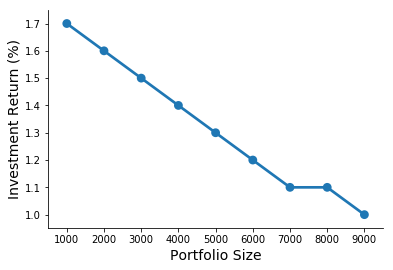

In [45]:
## Test the best-performing data-driven strategy on different portfolio sizes

result_sensitivity = []

## Vary the portfolio size from 1,000 to 10,000
for num_loans in list(range(1000,10000,1000)):
  
    reg_0 = test_investments(data_dict,classifier = random_forest,
                        regressor = reg_separate,strategy = 'Default-return-based', 
                        num_loans = num_loans,
                        random_state = default_seed,
                        output_to_file = False)
    result_sensitivity.append(reg_0['ret_PESS']['average return'])
    
result_sensitivity = np.array(result_sensitivity) * 100
sns.pointplot(np.array(list(range(1000,10000,1000))),result_sensitivity)
sns.despine()
plt.ylabel('Investment Return (%)',size = 14)
plt.xlabel('Portfolio Size',size = 14)
plt.show()